# **RAG + RAGAS + EXTRA METRICS**

In [1]:
import pkg_resources

for dist in sorted(pkg_resources.working_set, key=lambda d: d.project_name.lower()):
    print(f"{dist.project_name}=={dist.version}")


C:\Users\AZhaa\AppData\Local\Temp\ipykernel_13644\102525389.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


absl-py==2.3.1
accelerate==1.12.0
aiohappyeyeballs==2.6.1
aiohttp==3.13.2
aioitertools==0.13.0
aiosignal==1.4.0
aiosqlite==0.21.0
alembic==1.17.2
annotated-doc==0.0.4
annotated-types==0.7.0
anyio==4.11.0
appdirs==1.4.4
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
arize-phoenix==12.16.0
arize-phoenix-client==1.24.0
arize-phoenix-evals==2.6.0
arize-phoenix-otel==0.14.0
arrow==1.4.0
asttokens==3.0.1
async-lru==2.0.5
async-timeout==4.0.3
attrs==25.4.0
authlib==1.6.5
autocommand==2.2.2
babel==2.17.0
backoff==2.2.1
backports.tarfile==1.2.0
banks==2.2.0
bcrypt==5.0.0
beautifulsoup4==4.14.2
bleach==6.3.0
brotlicffi==1.1.0.0
build==1.3.0
cachetools==6.2.2
certifi==2025.11.12
cffi==2.0.0
cfgv==3.5.0
charset-normalizer==3.4.4
chromadb==1.3.7
click==8.3.1
colorama==0.4.6
coloredlogs==15.0.1
comm==0.2.3
contourpy==1.3.2
cryptography==46.0.3
cycler==0.12.1
dataclasses-json==0.6.7
datasets==4.4.1
debugpy==1.8.17
decorator==5.2.1
defusedxml==0.7.1
Deprecated==1.2.18
dill==0.4.0
dirtyjson==1.0.8
di

In [1]:
import json
from pathlib import Path
from typing import List, Dict
import pandas as pd

BASE_DIR = Path("arabicaqa_rag_results/dataset")

# Optional: simple cleaner
def clean_text(text: str) -> str:
    if text is None:
        return ""
    return str(text).strip()

def flatten_qa_split(json_path: Path, split_name: str) -> pd.DataFrame:
    """
    Load one QA JSON file (MRC or Open-Domain with context)
    and flatten it into a DataFrame.
    """
    with open(json_path, "r", encoding="utf-8") as f:
        raw = json.load(f)

    records: List[Dict] = []

    for article in raw["data"]:
        for para in article["paragraphs"]:
            context = clean_text(para.get("context", ""))
            document_id = para.get("document_id")

            for qa in para["qas"]:
                question = clean_text(qa.get("question", ""))
                # base is_impossible flag (from file if present)
                is_impossible = bool(qa.get("is_impossible", False))

                answers_list = qa.get("answers", [])
                answer_texts = [clean_text(a.get("text", "")) for a in answers_list]

                # ---- NEW LOGIC: '.' = unanswerable ----
                # if the only answer is "." → treat as unanswerable
                has_only_dot = (
                    len(answer_texts) > 0
                    and all(ans == "." for ans in answer_texts)
                )

                if has_only_dot:
                    is_impossible = True
                    # Usually for unanswerable we keep answers empty
                    answer_texts = []

                # Also: if there are no answers at all, mark as impossible
                if len(answer_texts) == 0:
                    is_impossible = True

                records.append(
                    {
                        "split": split_name,       # train / validation / test
                        "document_id": document_id,
                        "question_id": qa.get("id"),
                        "question": question,
                        "context": context,
                        "answers": answer_texts,   # list of strings
                        "is_impossible": is_impossible,
                    }
                )

    return pd.DataFrame(records)

# ---- Build all three MRC splits ----
df_train_mrc = flatten_qa_split(BASE_DIR / "MRC" / "train.json", "train")
df_val_mrc   = flatten_qa_split(BASE_DIR / "MRC" / "validation.json", "validation")
df_test_mrc  = flatten_qa_split(BASE_DIR / "MRC" / "test.json", "test")

# (Optional) If Open-Domain uses the same structure & has context now:
# df_train_open = flatten_qa_split(BASE_DIR / "Open-Domain" / "train.json", "train")
# df_val_open   = flatten_qa_split(BASE_DIR / "Open-Domain" / "validation.json", "validation")
# df_test_open  = flatten_qa_split(BASE_DIR / "Open-Domain" / "test.json", "test")

# ---- Merge MRC into one DataFrame ----
df_all_mrc = pd.concat([df_train_mrc, df_val_mrc, df_test_mrc], ignore_index=True)

df_all_mrc.head()


,split,document_id,question_id,question,context,answers,is_impossible
0,train,1338857,645198,ما هو عدد المقاطعات في إستونيا؟,إستونيا ، رسميًا جمهورية إستونيا ؛ هي دولة تقع...,[15],False
1,train,1338857,645409,ما هي أكبر طائفة مسيحية في إستونيا؟,إستونيا ، رسميًا جمهورية إستونيا ؛ هي دولة تقع...,[الكنيسة الإنجيلية اللوثرية الإستونية],False
2,train,1338857,645410,كم عدد المسلمين في إستونيا؟,إستونيا ، رسميًا جمهورية إستونيا ؛ هي دولة تقع...,[المسلمين يتجاوز عددهم 10000],False
3,train,1338857,645203,ما هو عدد سكان إستونيا؟,إستونيا ، رسميًا جمهورية إستونيا ؛ هي دولة تقع...,"[1,319,133مليون نسمة]",False
4,train,1338857,645202,ما هي عاصمة إستونيا؟,إستونيا ، رسميًا جمهورية إستونيا ؛ هي دولة تقع...,[تالين],False


In [24]:
from pathlib import Path
import pandas as pd
import json

BASE_DIR = Path("arabicaqa_rag_results/dataset")
BASE_DIR.mkdir(parents=True, exist_ok=True)

df_export = df_all_mrc.copy()

list_columns = ["answers"]  # ضع الأعمدة التي تحتوي قوائم

# تحويل القوائم إلى JSON string
for col in list_columns:
    df_export[col] = df_export[col].apply(
        lambda x: json.dumps(x, ensure_ascii=False) if isinstance(x, list) else "[]"
    )

df_export.to_csv(BASE_DIR / "df_all_mrc.csv", index=False, encoding="utf-8-sig")

print("✅ df_all_mrc.csv saved")


✅ df_all_mrc.csv saved


In [97]:
import pandas as pd
import json

df_all_mrc = pd.read_csv("arabicaqa_rag_results/dataset/df_all_mrc.csv")

list_columns = ["answers"]

for col in list_columns:
    df_all_mrc[col] = df_all_mrc[col].apply(lambda x: json.loads(x) if isinstance(x, str) else [])


| **Category**            | **Training** | **Validation** | **Test** | **Total**  |
| ----------------------- | ------------ | -------------- | -------- | ---------- |
|<mark> **MRC (with answers)**  | 62,186       | 13,483         | 13,426   | **89,095**|
|<mark> **MRC (unanswerable)**  | 2,596        | 561            | 544      | **3,701**  |
| **Open-Domain**         | 62,057       | 13,475         | 13,414   | **88,946** |
| **Open-Domain (Human)** | 58,676       | 12,715         | 12,592   | **83,983** |

We will take a sample of **MRC (with answers)** and **MRC (unanswerable)** => 500 form each part => Total 1000

In [98]:
df_all_mrc["is_impossible"].value_counts()

is_impossible
False    89095
True      3701
Name: count, dtype: int64

In [99]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# ============= 1) Helper functions =============

def word_count(text: str) -> int:
    if pd.isna(text):
        return 0
    return len(str(text).split())

latin_pattern = re.compile(r"[A-Za-z]")

def foreign_word_count(text: str) -> int:
    if pd.isna(text):
        return 0
    tokens = str(text).split()
    return sum(1 for t in tokens if latin_pattern.search(t))


# ============= 2) Compute statistics =============

# Lengths
df_all_mrc["context_word_len"] = df_all_mrc["context"].apply(word_count)
df_all_mrc["question_word_len"] = df_all_mrc["question"].apply(word_count)

# Number of answers
def answers_len_safe(x):
    if isinstance(x, list):
        return len(x)
    return 0

df_all_mrc["n_answers"] = df_all_mrc["answers"].apply(answers_len_safe)

# Answer lengths (flatten all answers)
all_answer_lengths = []
for ans_list in df_all_mrc["answers"]:
    if isinstance(ans_list, list):
        for a in ans_list:
            all_answer_lengths.append(word_count(a))

mean_answer_len = float(np.mean(all_answer_lengths)) if all_answer_lengths else 0.0

# Foreign words in context
df_all_mrc["context_foreign_word_count"] = df_all_mrc["context"].apply(
    foreign_word_count
)

# Means
mean_context_len = df_all_mrc["context_word_len"].mean()
mean_question_len = df_all_mrc["question_word_len"].mean()
mean_n_answers = df_all_mrc["n_answers"].mean()
mean_foreign_per_context = df_all_mrc["context_foreign_word_count"].mean()

print("📊 Dataset stats (MRC):")
print(f"- Mean context length (words):        {mean_context_len:.2f}")
print(f"- Mean question length (words):       {mean_question_len:.2f}")
print(f"- Mean #answers per question:         {mean_n_answers:.2f}")
print(f"- Mean answer length (words, global): {mean_answer_len:.2f}")
print(f"- Mean foreign words per context:     {mean_foreign_per_context:.2f}")

📊 Dataset stats (MRC):
- Mean context length (words):        456.87
- Mean question length (words):       7.71
- Mean #answers per question:         0.96
- Mean answer length (words, global): 8.83
- Mean foreign words per context:     2.20


Saved → arabicaqa_rag_results/ragas_full\figures_full\full_means_bar.png
Saved → arabicaqa_rag_results/ragas_full\figures_full\full_means_bar.pdf


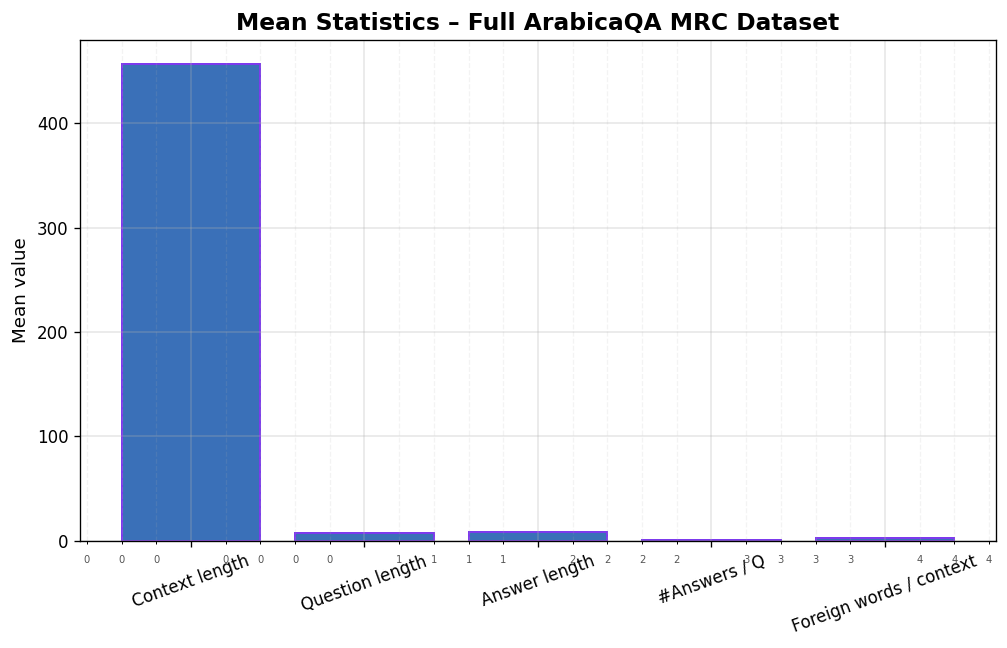

Saved → arabicaqa_rag_results/ragas_full\figures_full\full_hist_context_length.png
Saved → arabicaqa_rag_results/ragas_full\figures_full\full_hist_context_length.pdf


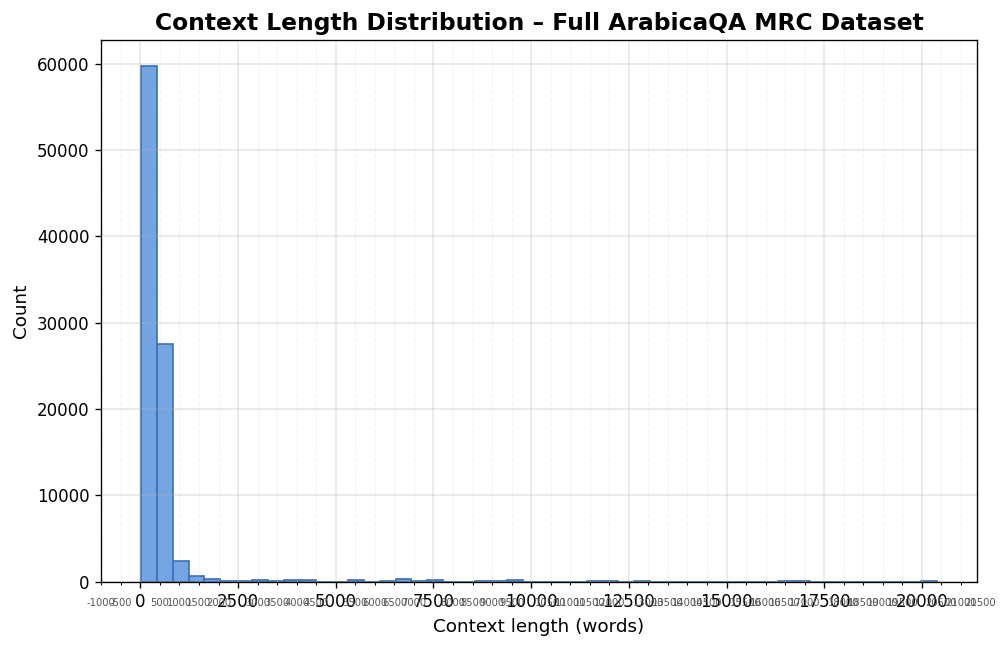

Saved → arabicaqa_rag_results/ragas_full\figures_full\full_hist_question_length.png
Saved → arabicaqa_rag_results/ragas_full\figures_full\full_hist_question_length.pdf


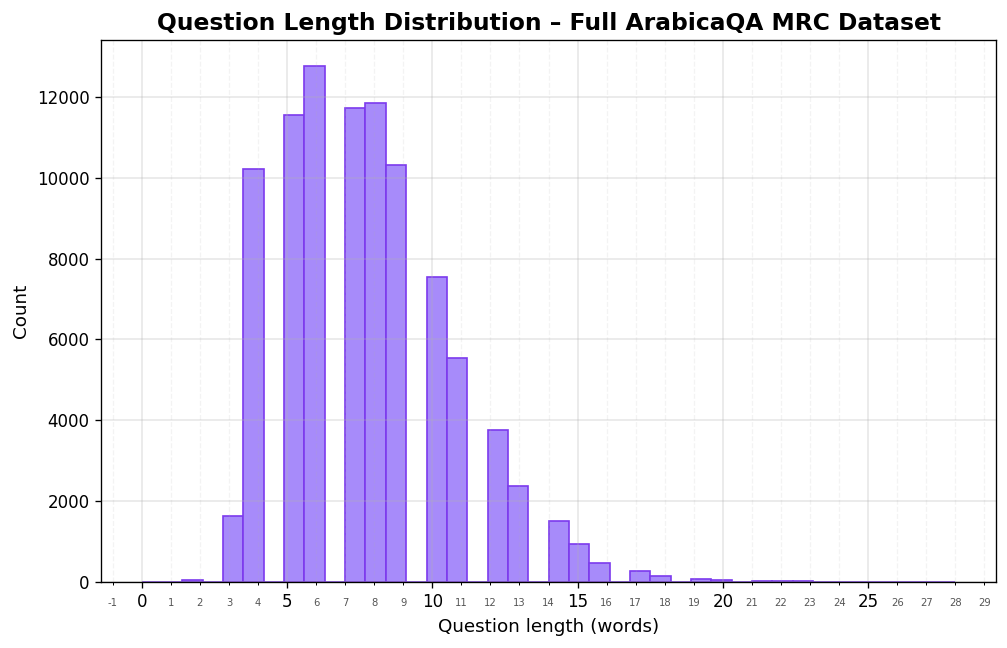

Saved → arabicaqa_rag_results/ragas_full\figures_full\full_hist_answer_length.png
Saved → arabicaqa_rag_results/ragas_full\figures_full\full_hist_answer_length.pdf


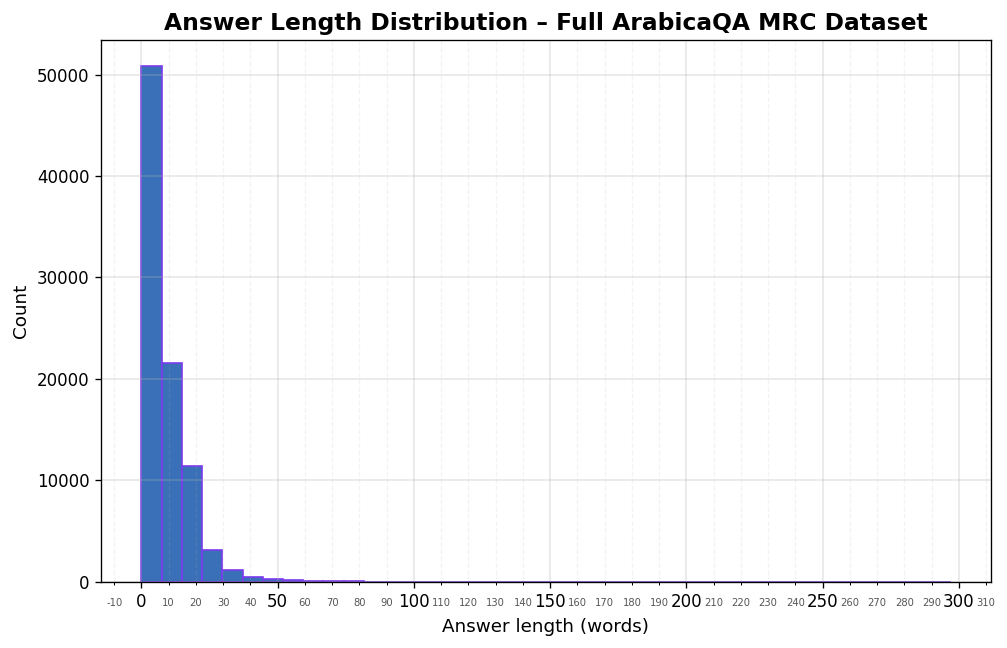

Saved → arabicaqa_rag_results/ragas_full\figures_full\full_hist_foreign_words.png
Saved → arabicaqa_rag_results/ragas_full\figures_full\full_hist_foreign_words.pdf


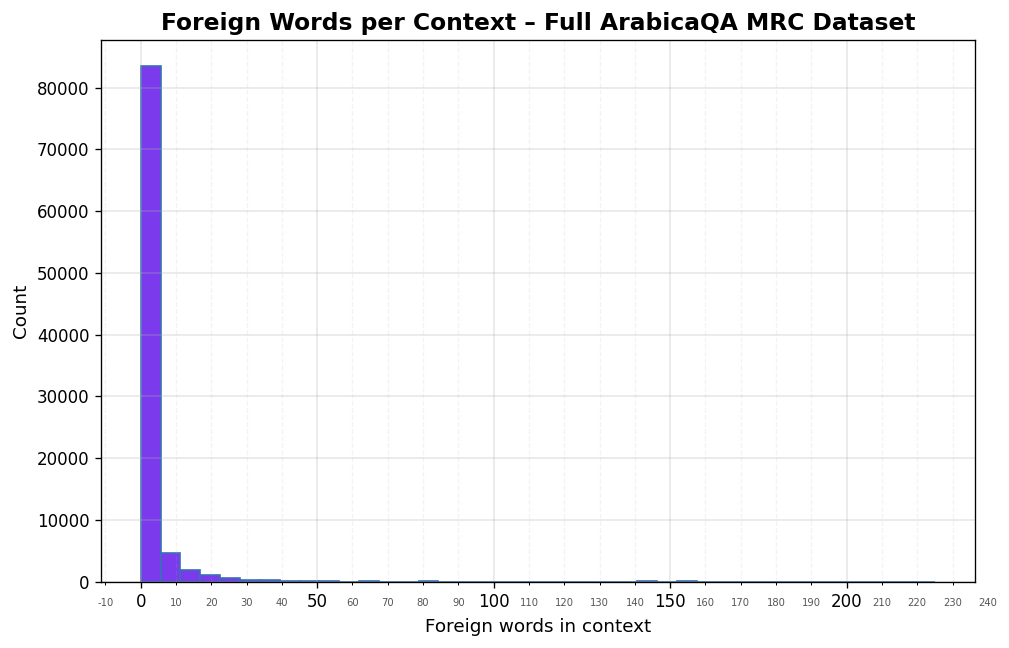

In [100]:
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# ======================
# PATHS
# ======================
OUTPUT_DIR = "arabicaqa_rag_results/ragas_full"
FIG_DIR = os.path.join(OUTPUT_DIR, "figures_full")
os.makedirs(FIG_DIR, exist_ok=True)

# ======================
# THEME
# ======================
PRIMARY   = "#3A70B8"   # Blue
SECONDARY = "#73A5E3"   # Light Blue
ACCENT1   = "#A78BFA"   # Light Purple
ACCENT2   = "#7C3AED"   # Purple

plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["figure.dpi"] = 120

def apply_style_with_minor_ticks(ax):
    """Apply theme + grid + minor ticks labels"""
    ax.grid(which="major", alpha=0.3, linewidth=1)
    ax.grid(which="minor", alpha=0.15, linestyle="--")

    ax.xaxis.set_minor_locator(AutoMinorLocator(5))

    minor_ticks = ax.xaxis.get_minorticklocs()
    for tick in minor_ticks:
        ax.text(
            tick,
            -0.045,
            f"{int(tick)}",
            transform=ax.get_xaxis_transform(),
            fontsize=6,
            color="#555",
            ha="center"
        )

    plt.tight_layout()

def save_fig(name_base: str):
    """Save current figure as PNG + PDF."""
    png_path = os.path.join(FIG_DIR, f"{name_base}.png")
    pdf_path = os.path.join(FIG_DIR, f"{name_base}.pdf")
    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    print("Saved →", png_path)
    print("Saved →", pdf_path)


# ======================================================
# 3) Bar plot of the means
# ======================================================
labels = [
    "Context length",
    "Question length",
    "Answer length",
    "#Answers / Q",
    "Foreign words / context",
]

values = [
    mean_context_len,
    mean_question_len,
    mean_answer_len,
    mean_n_answers,
    mean_foreign_per_context,
]

fig, ax = plt.subplots(figsize=(8.5, 5.5))
ax.bar(labels, values, color=PRIMARY, edgecolor=ACCENT2, linewidth=1.2)
ax.set_ylabel("Mean value")
ax.set_title("Mean Statistics – Full ArabicaQA MRC Dataset", fontsize=14)
ax.tick_params(axis="x", rotation=20)
apply_style_with_minor_ticks(ax)

save_fig("full_means_bar")
plt.show()


# ======================================================
# 4) Histograms for FULL DATA
# ======================================================

# ========= Context length =========
fig, ax = plt.subplots(figsize=(8.5, 5.5))
ax.hist(df_all_mrc["context_word_len"], bins=50, color=SECONDARY, edgecolor=PRIMARY)
ax.set_xlabel("Context length (words)")
ax.set_ylabel("Count")
ax.set_title("Context Length Distribution – Full ArabicaQA MRC Dataset", fontsize=14)
apply_style_with_minor_ticks(ax)

save_fig("full_hist_context_length")
plt.show()


# ========= Question length =========
fig, ax = plt.subplots(figsize=(8.5, 5.5))
ax.hist(df_all_mrc["question_word_len"], bins=40, color=ACCENT1, edgecolor=ACCENT2)
ax.set_xlabel("Question length (words)")
ax.set_ylabel("Count")
ax.set_title("Question Length Distribution – Full ArabicaQA MRC Dataset", fontsize=14)
apply_style_with_minor_ticks(ax)

save_fig("full_hist_question_length")
plt.show()


# ========= Answer length =========
fig, ax = plt.subplots(figsize=(8.5, 5.5))
ax.hist(all_answer_lengths, bins=40, color=PRIMARY, edgecolor=ACCENT2)
ax.set_xlabel("Answer length (words)")
ax.set_ylabel("Count")
ax.set_title("Answer Length Distribution – Full ArabicaQA MRC Dataset", fontsize=14)
apply_style_with_minor_ticks(ax)

save_fig("full_hist_answer_length")
plt.show()


# ========= Foreign words per context =========
fig, ax = plt.subplots(figsize=(8.5, 5.5))
ax.hist(df_all_mrc["context_foreign_word_count"], bins=40, color=ACCENT2, edgecolor=PRIMARY)
ax.set_xlabel("Foreign words in context")
ax.set_ylabel("Count")
ax.set_title("Foreign Words per Context – Full ArabicaQA MRC Dataset", fontsize=14)
apply_style_with_minor_ticks(ax)

save_fig("full_hist_foreign_words")
plt.show()


In [43]:
import pandas as pd
import json

# ========== 1) Read dataset ==========
df = pd.read_csv("arabicaqa_rag_results/dataset/df_all_mrc.csv")

# ========== 2) Decode list-like columns stored as JSON strings ==========
list_columns = ["answers"]   # عدّليها لو عندك أعمدة أخرى فيها lists

for col in list_columns:
    df[col] = df[col].apply(
        lambda x: json.loads(x) if isinstance(x, str) and x.strip().startswith("[") else []
    )

# ========== 3) Split dataset into answerable / unanswerable ==========
df_answerable = df[df["is_impossible"] == False]
df_unanswerable = df[df["is_impossible"] == True]

# ========== 4) Sample 500 from each ==========
sample_answerable = df_answerable.sample(500, random_state=42)
sample_unanswerable = df_unanswerable.sample(500, random_state=42)

# ========== 5) Combine into final sample ==========
df_sample = pd.concat([sample_answerable, sample_unanswerable], ignore_index=True)

print("Sample shape:", df_sample.shape)
df_sample.head()


Sample shape: (1000, 7)


,split,document_id,question_id,question,context,answers,is_impossible
0,train,1732461,1193607,متي تم بناء الموقع الأول لشركة توب غولف؟,توب غولف هي شركة ترفيهية رياضية عالمية مقرها ف...,[عام 2000],False
1,test,1583712,1160774,كم عدد الحفريات التي تم اكتشافها لببر نغاندونغ؟,ببر نغاندونغ هو نويع منقرض من أنواع الببور الح...,[سبع حفريات],False
2,train,1718678,1164879,ما هو مركز اللاعب ميو تساكتاش؟,ميو تساكتاش (8 مايو 1992 في سبليت في كرواتيا -...,[كصانع ألعاب],False
3,test,1582958,1068610,ما هي بعض المنتجات التي يمكن صنعها من القماش ا...,القماش الهَسِّيّ هو قماش منسوج يصنع عادة من أل...,[لصنع الحبال والشبكات والمنتجات المماثلة],False
4,test,1720179,1175188,ما هو مركز اللاعب رادو سابو؟,رادو سابو هو لاعب كرة قدم روماني في مركز الوسط...,[الوسط],False


In [ ]:
import pandas as pd
import json

# ======================================================
# 1) Load the sample
# ======================================================

df_sample = df_sample.copy()   # تأكدي أن df_sample موجود بالفعل


# ======================================================
# 2) Helper: safe parsing for list-columns (answers)
# ======================================================

def safe_parse_list(x):
    """Return a clean Python list, fixing formatting problems."""
    
    if isinstance(x, list):
        return x
    
    if pd.isna(x):
        return []
    
    s = str(x).strip()
    if s == "":
        return []

    # Try JSON as-is
    try:
        return json.loads(s)
    except:
        pass
    
    # Try JSON with single-quotes replaced
    try:
        s2 = s.replace("'", '"')
        return json.loads(s2)
    except:
        pass
    
    # Fallback: return as single-item list
    return [s]


# ======================================================
# 3) Fix list-columns (answers)
# ======================================================

list_columns = ["answers"]

for col in list_columns:
    df_sample[col] = df_sample[col].apply(safe_parse_list)


# ======================================================
# 4) Clean other text columns: strip whitespace, ensure strings
# ======================================================

text_columns = ["question", "context"]

for col in text_columns:
    df_sample[col] = df_sample[col].fillna("").astype(str).str.strip()


# ======================================================
# 5) Optional safety checks (remove broken rows)
# ======================================================

# Remove empty context/question rows (rare but safe)
df_sample = df_sample[df_sample["question"] != ""]
df_sample = df_sample[df_sample["context"] != ""]

# Ensure is_impossible is boolean
df_sample["is_impossible"] = df_sample["is_impossible"].astype(bool)


# ======================================================
# 6) Save cleaned sample
# ======================================================

output_path = "arabicaqa_rag_results/dataset/df_sample_1000.csv"

# Convert lists into JSON before saving
df_to_save = df_sample.copy()
for col in list_columns:
    df_to_save[col] = df_to_save[col].apply(lambda x: json.dumps(x, ensure_ascii=False))

df_to_save.to_csv(output_path, index=False, encoding="utf-8-sig")

print("✨ Sample cleaned and saved to:", output_path)
print("Final shape:", df_sample.shape)


In [1]:
import pandas as pd
import json

# ========== Load sample ==========
sample_path = "arabicaqa_rag_results/dataset/df_sample_1000.csv"
df_sample_loaded = pd.read_csv(sample_path)

# ========== Fix list columns after loading ==========
list_columns = ["answers"]

for col in list_columns:
    df_sample_loaded[col] = df_sample_loaded[col].apply(
        lambda x: json.loads(x) if isinstance(x, str) and x.strip().startswith("[") else []
    )

print("✨ Loaded sample shape:", df_sample_loaded.shape)
df_sample_loaded.head()


✨ Loaded sample shape: (1000, 7)


,split,document_id,question_id,question,context,answers,is_impossible
0,train,1732461,1193607,متي تم بناء الموقع الأول لشركة توب غولف؟,توب غولف هي شركة ترفيهية رياضية عالمية مقرها ف...,[عام 2000],False
1,test,1583712,1160774,كم عدد الحفريات التي تم اكتشافها لببر نغاندونغ؟,ببر نغاندونغ هو نويع منقرض من أنواع الببور الح...,[سبع حفريات],False
2,train,1718678,1164879,ما هو مركز اللاعب ميو تساكتاش؟,ميو تساكتاش (8 مايو 1992 في سبليت في كرواتيا -...,[كصانع ألعاب],False
3,test,1582958,1068610,ما هي بعض المنتجات التي يمكن صنعها من القماش ا...,القماش الهَسِّيّ هو قماش منسوج يصنع عادة من أل...,[لصنع الحبال والشبكات والمنتجات المماثلة],False
4,test,1720179,1175188,ما هو مركز اللاعب رادو سابو؟,رادو سابو هو لاعب كرة قدم روماني في مركز الوسط...,[الوسط],False


In [6]:
import numpy as np
import re

def word_count(text: str) -> int:
    if pd.isna(text):
        return 0
    return len(str(text).split())

latin_pattern = re.compile(r"[A-Za-z]")

def foreign_word_count(text: str) -> int:
    if pd.isna(text):
        return 0
    tokens = str(text).split()
    return sum(1 for t in tokens if latin_pattern.search(t))


df_sample_loaded["context_word_len"] = df_sample_loaded["context"].apply(word_count)
df_sample_loaded["question_word_len"] = df_sample_loaded["question"].apply(word_count)

df_sample_loaded["n_answers"] = df_sample_loaded["answers"].apply(lambda x: len(x) if isinstance(x, list) else 0)

# answer lengths (global)
all_sample_answer_lengths = []
for ans_list in df_sample_loaded["answers"]:
    if isinstance(ans_list, list):
        for a in ans_list:
            all_sample_answer_lengths.append(word_count(a))

mean_context_len_s = df_sample_loaded["context_word_len"].mean()
mean_question_len_s = df_sample_loaded["question_word_len"].mean()
mean_n_answers_s = df_sample_loaded["n_answers"].mean()
mean_answer_len_s = np.mean(all_sample_answer_lengths) if all_sample_answer_lengths else 0
df_sample_loaded["foreign_words"] = df_sample_loaded["context"].apply(foreign_word_count)
mean_foreign_s = df_sample_loaded["foreign_words"].mean()

print("📊 Sample stats:")
print(f"- Mean context length (words):        {mean_context_len_s:.2f}")
print(f"- Mean question length (words):       {mean_question_len_s:.2f}")
print(f"- Mean #answers per question:         {mean_n_answers_s:.2f}")
print(f"- Mean answer length (words, global): {mean_answer_len_s:.2f}")
print(f"- Mean foreign words per context:     {mean_foreign_s:.2f}")


📊 Sample stats:
- Mean context length (words):        372.58
- Mean question length (words):       8.24
- Mean #answers per question:         0.50
- Mean answer length (words, global): 8.47
- Mean foreign words per context:     1.90


In [8]:
print("df_sample_loaded rows:", len(df_sample_loaded))
print("context_word_len non-null:", df_sample_loaded["context_word_len"].notna().sum())
print("unique context_word_len:", df_sample_loaded["context_word_len"].nunique(dropna=True))
print(df_sample_loaded["context_word_len"].describe())


df_sample_loaded rows: 1000
context_word_len non-null: 1000
unique context_word_len: 484
count    1000.000000
mean      372.585000
std       588.171091
min        12.000000
25%        89.000000
50%       296.500000
75%       500.000000
max      9463.000000
Name: context_word_len, dtype: float64


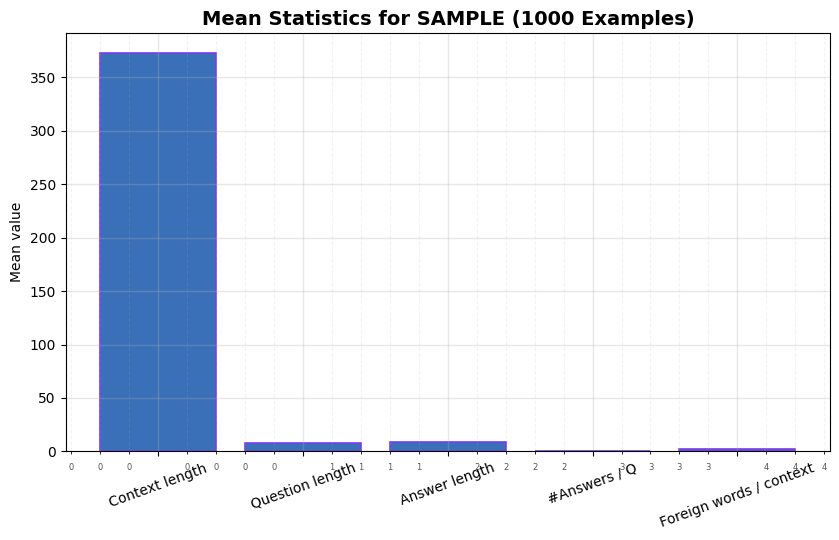

Saved → arabicaqa_rag_results/ragas_full\figures\mean_statistics_sample.png
Saved → arabicaqa_rag_results/ragas_full\figures\mean_statistics_sample.pdf


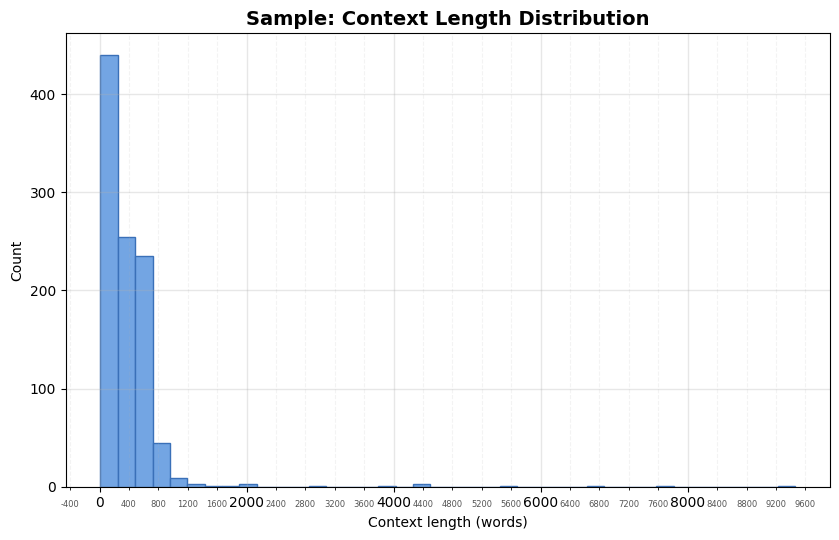

Saved → arabicaqa_rag_results/ragas_full\figures\hist_context_length.png
Saved → arabicaqa_rag_results/ragas_full\figures\hist_context_length.pdf


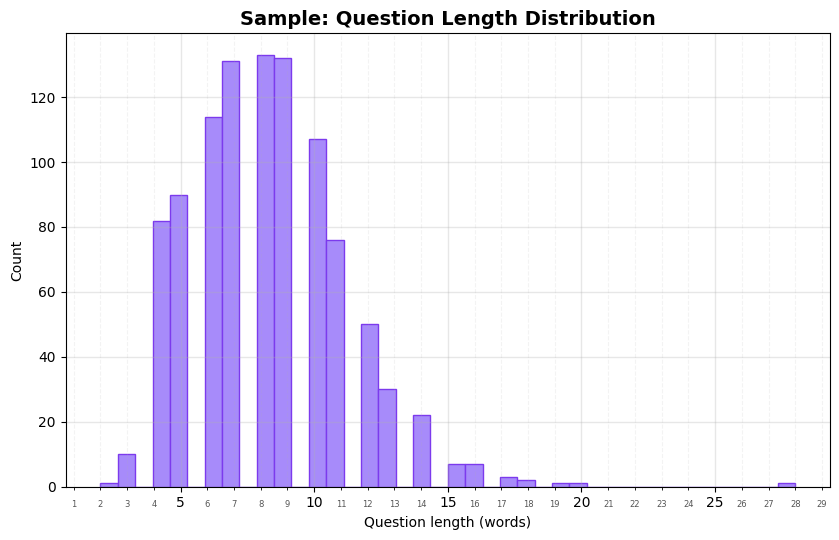

Saved → arabicaqa_rag_results/ragas_full\figures\hist_question_length.png
Saved → arabicaqa_rag_results/ragas_full\figures\hist_question_length.pdf


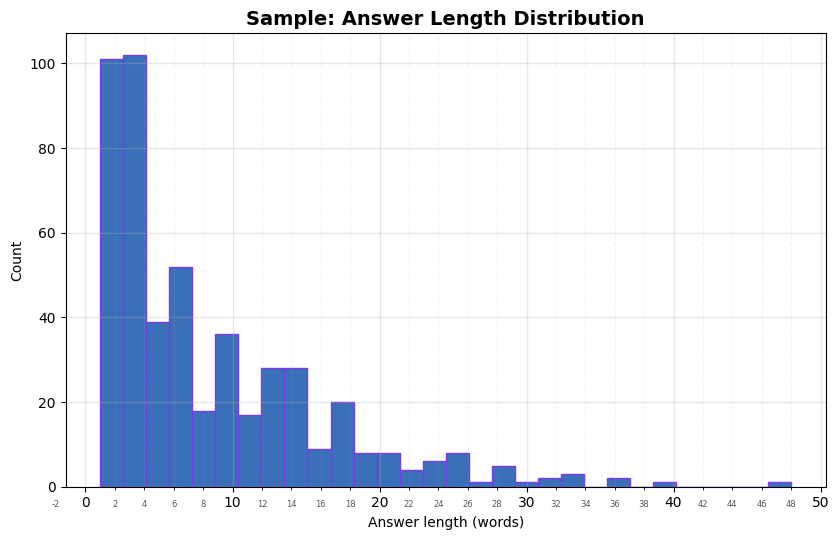

Saved → arabicaqa_rag_results/ragas_full\figures\hist_answer_length.png
Saved → arabicaqa_rag_results/ragas_full\figures\hist_answer_length.pdf


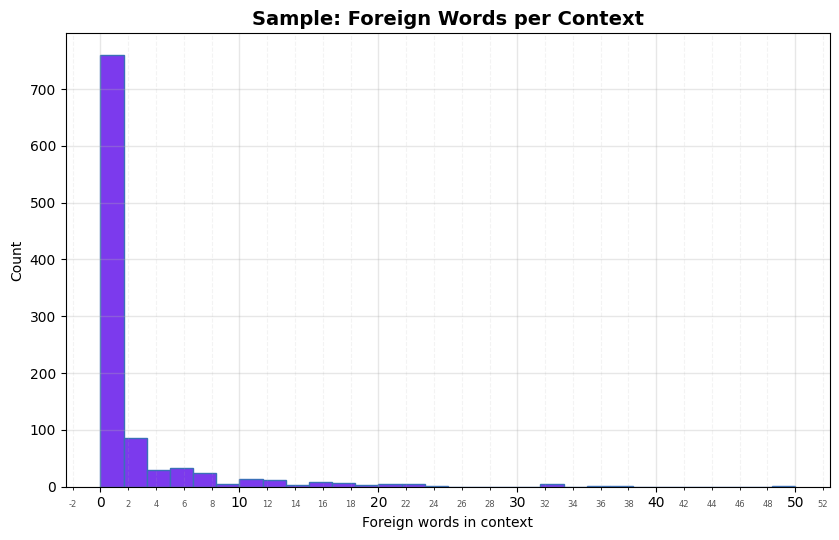

Saved → arabicaqa_rag_results/ragas_full\figures\hist_foreign_words.png
Saved → arabicaqa_rag_results/ragas_full\figures\hist_foreign_words.pdf


In [13]:
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# ======================
# PATHS
# ======================
OUTPUT_DIR = "arabicaqa_rag_results/ragas_full"
FIG_DIR = os.path.join(OUTPUT_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)

# ======================
# THEME
# ======================
plt.style.use("default")

PRIMARY   = "#3A70B8"   # Blue
SECONDARY = "#73A5E3"   # Light Blue
ACCENT1   = "#A78BFA"   # Light Purple
ACCENT2   = "#7C3AED"   # Purple


def apply_style_with_minor_ticks(ax):
    """Apply theme + grid + minor ticks with small labels"""
    ax.grid(which="major", alpha=0.3, linewidth=1)
    ax.grid(which="minor", alpha=0.15, linestyle="--")

    ax.xaxis.set_minor_locator(AutoMinorLocator(5))

    minor_ticks = ax.xaxis.get_minorticklocs()
    for tick in minor_ticks:
        ax.text(
            tick,
            -0.045,
            f"{int(tick)}",
            transform=ax.get_xaxis_transform(),
            fontsize=6,
            color="#555555",
            ha="center"
        )

    plt.tight_layout()


# =====================================================
# 1) BAR CHART — MEAN STATISTICS
# =====================================================
labels = [
    "Context length",
    "Question length",
    "Answer length",
    "#Answers / Q",
    "Foreign words / context",
]

values = [
    mean_context_len_s,
    mean_question_len_s,
    mean_answer_len_s,
    mean_n_answers_s,
    mean_foreign_s,
]

fig, ax = plt.subplots(figsize=(8.5, 5.5))
ax.bar(labels, values, color=PRIMARY, edgecolor=ACCENT2, linewidth=1.2)
ax.set_ylabel("Mean value")
ax.set_title("Mean Statistics for SAMPLE (1000 Examples)", fontsize=14, weight="bold")
ax.tick_params(axis="x", rotation=20)

apply_style_with_minor_ticks(ax)

png = os.path.join(FIG_DIR, "mean_statistics_sample.png")
pdf = os.path.join(FIG_DIR, "mean_statistics_sample.pdf")
plt.savefig(png, dpi=300, bbox_inches="tight")
plt.savefig(pdf, bbox_inches="tight")
plt.show()

print("Saved →", png)
print("Saved →", pdf)


# =====================================================
# 2) HISTOGRAM — CONTEXT LENGTH
# =====================================================
fig, ax = plt.subplots(figsize=(8.5, 5.5))
ax.hist(df_sample_loaded["context_word_len"], bins=40,
        color=SECONDARY, edgecolor=PRIMARY)

ax.set_xlabel("Context length (words)")
ax.set_ylabel("Count")
ax.set_title("Sample: Context Length Distribution", fontsize=14, weight="bold")

apply_style_with_minor_ticks(ax)

png = os.path.join(FIG_DIR, "hist_context_length.png")
pdf = os.path.join(FIG_DIR, "hist_context_length.pdf")
plt.savefig(png, dpi=300, bbox_inches="tight")
plt.savefig(pdf, bbox_inches="tight")
plt.show()

print("Saved →", png)
print("Saved →", pdf)


# =====================================================
# 3) HISTOGRAM — QUESTION LENGTH
# =====================================================
fig, ax = plt.subplots(figsize=(8.5, 5.5))
ax.hist(df_sample_loaded["question_word_len"], bins=40,
        color=ACCENT1, edgecolor=ACCENT2)

ax.set_xlabel("Question length (words)")
ax.set_ylabel("Count")
ax.set_title("Sample: Question Length Distribution", fontsize=14, weight="bold")

apply_style_with_minor_ticks(ax)

png = os.path.join(FIG_DIR, "hist_question_length.png")
pdf = os.path.join(FIG_DIR, "hist_question_length.pdf")
plt.savefig(png, dpi=300, bbox_inches="tight")
plt.savefig(pdf, bbox_inches="tight")
plt.show()

print("Saved →", png)
print("Saved →", pdf)


# =====================================================
# 4) HISTOGRAM — ANSWER LENGTH
# =====================================================
fig, ax = plt.subplots(figsize=(8.5, 5.5))
ax.hist(all_sample_answer_lengths, bins=30,
        color=PRIMARY, edgecolor=ACCENT2)

ax.set_xlabel("Answer length (words)")
ax.set_ylabel("Count")
ax.set_title("Sample: Answer Length Distribution", fontsize=14, weight="bold")

apply_style_with_minor_ticks(ax)

png = os.path.join(FIG_DIR, "hist_answer_length.png")
pdf = os.path.join(FIG_DIR, "hist_answer_length.pdf")
plt.savefig(png, dpi=300, bbox_inches="tight")
plt.savefig(pdf, bbox_inches="tight")
plt.show()

print("Saved →", png)
print("Saved →", pdf)


# =====================================================
# 5) HISTOGRAM — FOREIGN WORDS PER CONTEXT
# =====================================================
fig, ax = plt.subplots(figsize=(8.5, 5.5))
ax.hist(df_sample_loaded["foreign_words"], bins=30,
        color=ACCENT2, edgecolor=PRIMARY)

ax.set_xlabel("Foreign words in context")
ax.set_ylabel("Count")
ax.set_title("Sample: Foreign Words per Context", fontsize=14, weight="bold")

apply_style_with_minor_ticks(ax)

png = os.path.join(FIG_DIR, "hist_foreign_words.png")
pdf = os.path.join(FIG_DIR, "hist_foreign_words.pdf")
plt.savefig(png, dpi=300, bbox_inches="tight")
plt.savefig(pdf, bbox_inches="tight")
plt.show()

print("Saved →", png)
print("Saved →", pdf)


In [3]:
import pandas as pd
import json

# ========== Load sample ==========
sample_path = "arabicaqa_rag_results/dataset/df_sample_1000.csv"
df_sample_loaded = pd.read_csv(sample_path)

# ========== Fix list columns after loading ==========
list_columns = ["answers"]

for col in list_columns:
    df_sample_loaded[col] = df_sample_loaded[col].apply(
        lambda x: json.loads(x) if isinstance(x, str) and x.strip().startswith("[") else []
    )

print("✨ Loaded sample shape:", df_sample_loaded.shape)
df_sample_loaded.head()


✨ Loaded sample shape: (1000, 7)


,split,document_id,question_id,question,context,answers,is_impossible
0,train,1732461,1193607,متي تم بناء الموقع الأول لشركة توب غولف؟,توب غولف هي شركة ترفيهية رياضية عالمية مقرها ف...,[عام 2000],False
1,test,1583712,1160774,كم عدد الحفريات التي تم اكتشافها لببر نغاندونغ؟,ببر نغاندونغ هو نويع منقرض من أنواع الببور الح...,[سبع حفريات],False
2,train,1718678,1164879,ما هو مركز اللاعب ميو تساكتاش؟,ميو تساكتاش (8 مايو 1992 في سبليت في كرواتيا -...,[كصانع ألعاب],False
3,test,1582958,1068610,ما هي بعض المنتجات التي يمكن صنعها من القماش ا...,القماش الهَسِّيّ هو قماش منسوج يصنع عادة من أل...,[لصنع الحبال والشبكات والمنتجات المماثلة],False
4,test,1720179,1175188,ما هو مركز اللاعب رادو سابو؟,رادو سابو هو لاعب كرة قدم روماني في مركز الوسط...,[الوسط],False


In [9]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import pandas as pd
from tqdm import tqdm
from collections import Counter

model_id = "CAMeL-Lab/bert-base-arabic-camelbert-msa-ner"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForTokenClassification.from_pretrained(model_id)

ner = pipeline(
    "ner",
    model=model,
    tokenizer=tokenizer,
    aggregation_strategy="simple"
)

def get_entity_counts(texts, max_tokens=512):
    entity_counter = Counter()
    for t in tqdm(texts):
        if not isinstance(t, str) or not t.strip():
            continue

        # نعمل tokenize مع قصّ لحد max_tokens
        enc = tokenizer(
            t,
            truncation=True,
            max_length=max_tokens,
            return_tensors=None
        )
        # نرجع نص مقصوص بناء على التوكنز
        input_ids = enc["input_ids"]
        # لو رجعها list of ids (بدون batch)
        if isinstance(input_ids[0], int):
            truncated_text = tokenizer.decode(input_ids, skip_special_tokens=True)
        else:
            truncated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)

        # نرسل النص المقصوص للـ pipeline بدون براميترز إضافية
        ents = ner(truncated_text)
        for e in ents:
            entity_counter[e["entity_group"]] += 1

    return entity_counter


# ==============================
# SAMPLE entities (ACTIVE)
# ==============================
sample_contexts = df_sample_loaded["context"].dropna().tolist()

sample_entity_counts = get_entity_counts(sample_contexts)

print("\n=== SAMPLE NER STATISTICS ===")
for k, v in sample_entity_counts.items():
    print(f"{k}: {v}")

df_ner = pd.DataFrame({
    "entity_type": list(sample_entity_counts.keys()),
    "sample": list(sample_entity_counts.values()),
})
df_ner.head()


Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-msa-ner were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:53<00:00,  3.41it/s]


=== SAMPLE NER STATISTICS ===
ORG: 2058
LOC: 11581
PERS: 6686
MISC: 3737


,entity_type,sample
0,ORG,2058
1,LOC,11581
2,PERS,6686
3,MISC,3737


In [86]:
import pandas as pd

ner_results_path = "arabicaqa_rag_results/dataset/sample_ner_counts.csv"

df_ner_loaded = pd.read_csv(ner_results_path)

print("✨ Loaded NER results:")
print(df_ner_loaded.head())


✨ Loaded NER results:
  entity_type  sample
0         ORG    2058
1         LOC   11581
2        PERS    6686
3        MISC    3737


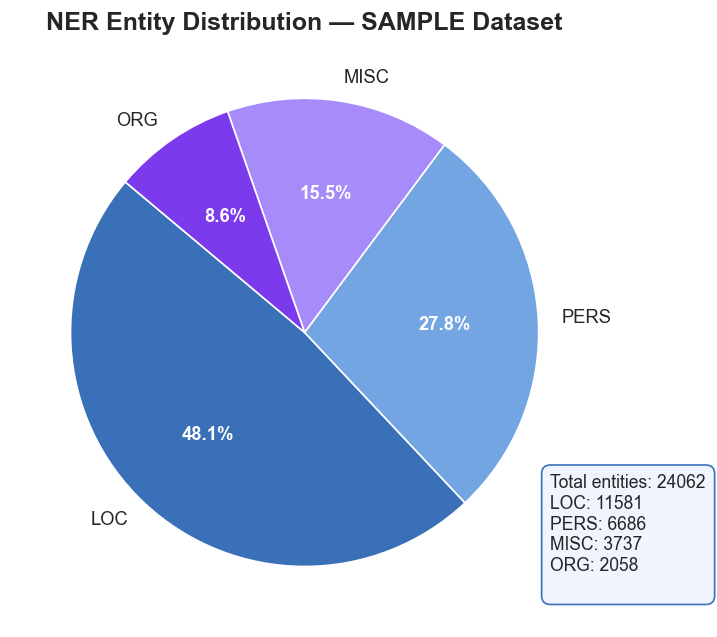

Saved → arabicaqa_rag_results/ragas_full\figures\ner_entity_distribution_pie.png
Saved → arabicaqa_rag_results/ragas_full\figures\ner_entity_distribution_pie.pdf


In [87]:
import os
import matplotlib.pyplot as plt

# ====== Theme colors ======
PRIMARY   = "#3A70B8"   # Blue
SECONDARY = "#73A5E3"   # Light Blue
ACCENT1   = "#A78BFA"   # Light Purple
ACCENT2   = "#7C3AED"   # Purple

colors = [PRIMARY, SECONDARY, ACCENT1, ACCENT2, "#4FB6A0", "#F2A93B", "#D96459"]

# ======================
# PATH
# ======================
FIG_DIR = os.path.join(OUTPUT_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)

# ======================
# PREPARE DATA
# ======================
df_plot = df_ner_loaded.sort_values("sample", ascending=False)

labels = df_plot["entity_type"].astype(str).tolist()
sizes  = df_plot["sample"].astype(float).tolist()

total_entities = int(sum(sizes))

# ======================
# PIE CHART
# ======================
fig, ax = plt.subplots(figsize=(6.5, 5.5))

patches, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    colors=colors[:len(labels)],
    startangle=140,
    textprops={"fontsize": 11}
)

# improve label style on wedges
for autotext in autotexts:
    autotext.set_color("white")
    autotext.set_fontsize(11)
    autotext.set_weight("bold")

ax.set_title("NER Entity Distribution — SAMPLE Dataset", fontsize=15, weight="bold")

# ========= Inset Box ==========
box_text = f"Total entities: {total_entities}\n"
for ent, count in zip(labels, sizes):
    box_text += f"{ent}: {int(count)}\n"

props = dict(boxstyle="round,pad=0.5", facecolor="#F0F4FF", edgecolor=PRIMARY)

ax.text(
    0.92, 0.05,                 # box position inside axes
    box_text,
    transform=ax.transAxes,
    fontsize=10.5,
    verticalalignment="bottom",
    horizontalalignment="left",
    bbox=props
)

plt.tight_layout()

# ======================
# SAVE
# ======================
png_path = os.path.join(FIG_DIR, "ner_entity_distribution_pie.png")
pdf_path = os.path.join(FIG_DIR, "ner_entity_distribution_pie.pdf")

plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.savefig(pdf_path, bbox_inches="tight")
plt.show()

print(f"Saved → {png_path}")
print(f"Saved → {pdf_path}")


# **RAG Pipeline**

In [11]:
import pandas as pd
import json

# ========== Load sample ==========
sample_path = "arabicaqa_rag_results/dataset/df_sample_1000.csv"
df_sample_loaded = pd.read_csv(sample_path)

# ========== Fix list columns after loading ==========
list_columns = ["answers"]

for col in list_columns:
    df_sample_loaded[col] = df_sample_loaded[col].apply(
        lambda x: json.loads(x) if isinstance(x, str) and x.strip().startswith("[") else []
    )

print("✨ Loaded sample shape:", df_sample_loaded.shape)
df_sample_loaded.head()


✨ Loaded sample shape: (1000, 7)


,split,document_id,question_id,question,context,answers,is_impossible
0,train,1732461,1193607,متي تم بناء الموقع الأول لشركة توب غولف؟,توب غولف هي شركة ترفيهية رياضية عالمية مقرها ف...,[عام 2000],False
1,test,1583712,1160774,كم عدد الحفريات التي تم اكتشافها لببر نغاندونغ؟,ببر نغاندونغ هو نويع منقرض من أنواع الببور الح...,[سبع حفريات],False
2,train,1718678,1164879,ما هو مركز اللاعب ميو تساكتاش؟,ميو تساكتاش (8 مايو 1992 في سبليت في كرواتيا -...,[كصانع ألعاب],False
3,test,1582958,1068610,ما هي بعض المنتجات التي يمكن صنعها من القماش ا...,القماش الهَسِّيّ هو قماش منسوج يصنع عادة من أل...,[لصنع الحبال والشبكات والمنتجات المماثلة],False
4,test,1720179,1175188,ما هو مركز اللاعب رادو سابو؟,رادو سابو هو لاعب كرة قدم روماني في مركز الوسط...,[الوسط],False


In [12]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_community.llms import Ollama
from langchain_classic.chains import RetrievalQA


print("✅ all imports OK (new LangChain)")


✅ all imports OK (new LangChain)


In [13]:
# ========= 1) جهّزي الـ corpus مع document_id =========
unique_contexts = (
    df_sample_loaded[["document_id", "context"]]
    .dropna(subset=["context"])
    .drop_duplicates(subset=["document_id"])
    .reset_index(drop=True)
)

len(unique_contexts), unique_contexts.iloc[0]["context"][:200]


(919,
 'توب غولف هي شركة ترفيهية رياضية عالمية مقرها في دالاس، تكساس ولها مواقع في الولايات المتحدة والمملكة المتحدة وأستراليا والمكسيك ودبي. تم الاستحواذ على الشركة من قبل Callaway Golf المتداولة علنًا في ما')

In [14]:
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)

unique_contexts = (
    df_sample_loaded[["document_id", "context"]]
    .dropna(subset=["context"])
    .drop_duplicates(subset=["document_id"])
    .reset_index(drop=True)
)

docs = []
for _, row in unique_contexts.iterrows():
    doc_id = int(row["document_id"])
    text = row["context"]

    chunks = text_splitter.split_text(text)
    for i, chunk in enumerate(chunks):
        docs.append(
            Document(
                page_content=chunk,
                metadata={"document_id": doc_id, "chunk_id": i}
            )
        )

print("Example metadata:", docs[0].metadata)
print(f"✅ Created {len(docs)} chunks")


Example metadata: {'document_id': 1732461, 'chunk_id': 0}
✅ Created 6026 chunks


In [15]:
# ========= 3) بناء الـ Vector DB (Chroma + HF embeddings) =========
from langchain_community.vectorstores import Chroma
from tqdm.auto import tqdm  

embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
)

vectordb = Chroma(
    collection_name="arabicaqa_mrc_v1_docid",   # اسم جديد
    embedding_function=embeddings,
    persist_directory="chroma_arabicaqa_docid"  # مجلد جديد
)

BATCH_SIZE = 5000
for i in tqdm(range(0, len(docs), BATCH_SIZE)):
    batch_docs = docs[i : i + BATCH_SIZE]
    vectordb.add_documents(batch_docs)

vectordb.persist()

retriever = vectordb.as_retriever(search_kwargs={"k": 5})


C:\Users\AZhaa\AppData\Local\Temp\ipykernel_23720\1959699818.py:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(
C:\Users\AZhaa\AppData\Local\Temp\ipykernel_23720\1959699818.py:9: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the `langchain-chroma package and should be used instead. To use it run `pip install -U `langchain-chroma` and import as `from `langchain_chroma import Chroma``.
  vectordb = Chroma(
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:36<00:00, 18.03s/it]
C:\Users\AZhaa

In [16]:
hits = retriever.invoke(df_sample_loaded["question"].iloc[0])
print(hits[0].metadata)


{'chunk_id': 4, 'document_id': 1732461}


In [7]:
import pandas as pd
import json
import time
import os
from tqdm import tqdm

from langchain_community.llms import Ollama
from langchain_core.prompts import PromptTemplate
from langchain_classic.chains import RetrievalQA

# ========== 1) Load the sample ==========
sample_path = "arabicaqa_rag_results/dataset/df_sample_1000.csv"
df_sample = pd.read_csv(sample_path)

# # ========== Smoke test: 5 Answerable + 5 Unanswerable ==========
# df_ans  = df_sample[df_sample["is_impossible"] == True].head(5)
# df_un   = df_sample[df_sample["is_impossible"] == False].head(5)

# df_sample = pd.concat([df_ans, df_un], ignore_index=True)

# print("Smoke test mode (5 answerable + 5 unanswerable):", df_sample.shape)
# print(df_sample["is_impossible"].value_counts())

# ========================================================================

# Fix list columns after CSV loading (answers as JSON list)
list_columns = ["answers"]  # لو عندك أعمدة أخرى من نوع list أضيفيها هنا
for col in list_columns:
    if col in df_sample.columns:
        df_sample[col] = df_sample[col].apply(
            lambda x: json.loads(x) if isinstance(x, str) and x.strip().startswith("[") else x
        )

print("Sample loaded successfully:", df_sample.shape)

# تأكد أن عمود is_impossible موجود
if "is_impossible" not in df_sample.columns:
    raise ValueError("Column 'is_impossible' is missing from df_sample!")

# ========== 2) Shared Prompt (نفس البرومبت للموديلين) ==========
template = """
أجب عن السؤال التالي باللغة العربية الفصحى فقط،
وبأقصر وأدق إجابة ممكنة.
لا تضف أي شرح أو مقدمة أو معلومات من خارج السياق.
إذا لم تكن الإجابة موجودة في السياق، اكتب فقط: "غير موجود في السياق."

السؤال: {question}

السياق:
{context}

الإجابة:
"""

prompt = PromptTemplate(
    template=template,
    input_variables=["question", "context"]
)

# ========== 3) Define the two models ==========
models = {
    "llama": "llama3:latest",
    "mistral": "mistral:7b-instruct",
}

# نفترض أن retriever موجود من قبل في النوتبوك
# retriever = vectordb.as_retriever(search_kwargs={"k": 5})

qa_chains = {}
for name, model_name in models.items():
    llm = Ollama(model=model_name, temperature=0.0)
    qa_chains[name] = RetrievalQA.from_chain_type(
        llm=llm,
        retriever=retriever,
        chain_type="stuff",
        chain_type_kwargs={"prompt": prompt},
        return_source_documents=False,
    )

# ========== 4) Run both models on all questions ==========
results = []

print("Starting dual-model RAG evaluation (Llama vs Mistral) on 1000 questions...\n")

for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample), desc="Processing questions"):
    question = row["question"]
    context = row.get("context", "")

    answer_llama = "ERROR"
    answer_mistral = "ERROR"

    # Run Llama
    try:
        # بعض إصدارات LangChain تفضّل هذا الشكل:
        answer_llama = qa_chains["llama"]({"query": question})["result"].strip()
    except Exception as e:
        print(f"\nLlama error on question {idx}: {e}")

    # Run Mistral
    try:
        answer_mistral = qa_chains["mistral"]({"query": question})["result"].strip()
    except Exception as e:
        print(f"\nMistral error on question {idx}: {e}")

    results.append({
        # من نفس الداتا الأصلية
        "row_idx": idx,                               # فهرس السطر في السامبل
        "split": row.get("split", ""),
        "document_id": row.get("document_id", ""),
        "question_id": row.get("question_id", ""),

        "question": question,
        "context": context,
        "correct_answers": row["answers"],           # قائمة الإجابات الصحيحة (list)

        # معلومات قابلية الإجابة
        "is_impossible": bool(row.get("is_impossible", False)),
        "is_answerable": not bool(row.get("is_impossible", False)),

        # مخرجات الموديلين
        "predicted_answer_llama": answer_llama,
        "predicted_answer_mistral": answer_mistral,
    })

    # نفس التوقف الصغير عشان Ollama ما يتعب
    time.sleep(0.15)

# ========== 5) Save results ==========
df_results = pd.DataFrame(results)

output_dir = "arabicaqa_rag_results/predictions"
os.makedirs(output_dir, exist_ok=True)

output_csv = f"{output_dir}/comparison_llama_vs_mistral_1000.csv"
output_json = f"{output_dir}/comparison_llama_vs_mistral_1000.json"

# ملاحظة: correct_answers عمود list → CSV راح يخزّنه كنص
df_results.to_csv(output_csv, index=False, encoding="utf-8-sig")
df_results.to_json(output_json, orient="records", lines=True, force_ascii=False)

print("\nAll done! Dual model evaluation completed.")
print(f"Results saved:")
print(f"   CSV  → {output_csv}")
print(f"   JSON → {output_json}")
print(f"   Total questions: {len(df_results)}")
print(f"   Llama errors:   {(df_results['predicted_answer_llama'] == 'ERROR').sum()}")
print(f"   Mistral errors: {(df_results['predicted_answer_mistral'] == 'ERROR').sum()}")


C:\Users\AZhaa\AppData\Local\Temp\ipykernel_21180\2281099099.py:71: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the `langchain-ollama package and should be used instead. To use it run `pip install -U `langchain-ollama` and import as `from `langchain_ollama import OllamaLLM``.
  llm = Ollama(model=model_name, temperature=0.0)


Sample loaded successfully: (1000, 7)
Starting dual-model RAG evaluation (Llama vs Mistral) on 1000 questions...



C:\Users\AZhaa\AppData\Local\Temp\ipykernel_21180\2281099099.py:95: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain-classic 0.1.0 and will be removed in 1.0. Use `invoke` instead.
  answer_llama = qa_chains["llama"]({"query": question})["result"].strip()
Processing questions: 100%|█████████████████████████████████████████████████████| 1000/1000 [13:58:17<00:00, 50.30s/it]


All done! Dual model evaluation completed.
Results saved:
   CSV  → arabicaqa_rag_results/predictions/comparison_llama_vs_mistral_1000.csv
   JSON → arabicaqa_rag_results/predictions/comparison_llama_vs_mistral_1000.json
   Total questions: 1000
   Llama errors:   0
   Mistral errors: 0


In [3]:
# ============================================================
# 0) Paths + Load df_results
# ============================================================
import os
import pandas as pd

output_dir = "arabicaqa_rag_results/predictions"
df_results_name = "comparison_llama_vs_mistral_1000.csv"
df_results_path = os.path.join(output_dir, df_results_name)

os.makedirs(output_dir, exist_ok=True)

if not os.path.exists(df_results_path):
    raise FileNotFoundError(f"df_results not found at: {df_results_path}")

df_results = pd.read_csv(df_results_path)
df_results.head()

,row_idx,split,document_id,question_id,question,context,correct_answers,is_impossible,is_answerable,predicted_answer_llama,predicted_answer_mistral
0,0,train,1732461,1193607,متي تم بناء الموقع الأول لشركة توب غولف؟,توب غولف هي شركة ترفيهية رياضية عالمية مقرها ف...,['عام 2000'],False,True,غير موجود في السياق.,غير موجود في السياق.
1,1,test,1583712,1160774,كم عدد الحفريات التي تم اكتشافها لببر نغاندونغ؟,ببر نغاندونغ هو نويع منقرض من أنواع الببور الح...,['سبع حفريات'],False,True,21,21 مقبرة تم اكتشافها لببر نغاندونغ.
2,2,train,1718678,1164879,ما هو مركز اللاعب ميو تساكتاش؟,ميو تساكتاش (8 مايو 1992 في سبليت في كرواتيا -...,['كصانع ألعاب'],False,True,مركز اللاعب ميو تساكتاش هو مركز اللاعب في لعبة...,غير موجود في السياق.
3,3,test,1582958,1068610,ما هي بعض المنتجات التي يمكن صنعها من القماش ا...,القماش الهَسِّيّ هو قماش منسوج يصنع عادة من أل...,['لصنع الحبال والشبكات والمنتجات المماثلة'],False,True,القماش.,بعض المنتجات التي يمكن صنعها من القماش الهسي ه...
4,4,test,1720179,1175188,ما هو مركز اللاعب رادو سابو؟,رادو سابو هو لاعب كرة قدم روماني في مركز الوسط...,['الوسط'],False,True,مركز اللاعب رادو سابو هو نان.,غير موجود في السياق.


In [3]:
# after your parsing (correct_answers is list)
def is_empty_gold(x):
    if x is None: return True
    if isinstance(x, float) and math.isnan(x): return True
    if isinstance(x, (list, tuple)):
        return len([str(t).strip() for t in x if str(t).strip()]) == 0
    return str(x).strip() == ""

empty_mask = df_results["correct_answers"].apply(is_empty_gold)

print("Empty gold count:", empty_mask.sum())
print("Empty gold %:", round(empty_mask.mean() * 100, 2))

print("\nEmpty gold but is_impossible=False count:",
      ((empty_mask) & (df_results["is_impossible"] == False)).sum())


Empty gold count: 500
Empty gold %: 50.0

Empty gold but is_impossible=False count: 0


In [21]:
import os
import json
import math
import ast
import re
import pandas as pd
from datetime import datetime
from evaluate import load

# ============================================================
# 0) Paths + Load df_results
# ============================================================
output_dir = "arabicaqa_rag_results/predictions"
df_results_name = "comparison_llama_vs_mistral_1000.csv"
df_results_path = os.path.join(output_dir, df_results_name)

os.makedirs(output_dir, exist_ok=True)

if not os.path.exists(df_results_path):
    raise FileNotFoundError(f"df_results not found at: {df_results_path}")

df_results = pd.read_csv(df_results_path)

print("\n" + "="*80)
print(" CALCULATING OFFICIAL SCORES")
print("="*80)
print(f"Loaded df_results: {df_results_path}")
print(f"Rows: {len(df_results):,} | Columns: {list(df_results.columns)}")

# ============================================================
# 1) Validate required columns
# ============================================================
required_cols = [
    "predicted_answer_llama",
    "predicted_answer_mistral",
    "correct_answers",
    "is_impossible"  # needed for proper reporting
]
missing = [c for c in required_cols if c not in df_results.columns]
if missing:
    raise KeyError(f"Missing required columns in df_results: {missing}")

# ============================================================
# Arabic normalization + No-answer detector (NEW)
# ============================================================
def normalize_arabic_text(s: str) -> str:
    if s is None:
        return ""
    s = str(s).strip()
    # remove Arabic + English punctuation (incl. Arabic comma/question mark)
    s = re.sub(r"[.,!?؟،؛:\"'«»ـ]", " ", s)
    return " ".join(s.split())

# Canonical no-answer label (used for scoring unanswerable rows)
NO_ANSWER = "غير موجود في السياق"
NO_ANSWER_CANON = normalize_arabic_text(NO_ANSWER)

# flexible: accept variants like "غير موجود في السياق." or "غير موجود في النص"
NO_ANSWER_PATTERNS = [
    r"غير موجود",
    r"غير متوفر",
    r"غير مذكور",
    r"ليس مذكور",
    r"لا (يوجد|توجد)",
    r"لا يذكر",
    r"لا تتوفر",
    r"لا يمكن (العثور|تحديد|الإجابة)",
]

def is_no_answer(text: str) -> bool:
    t = normalize_arabic_text(text)
    if not t:
        return False
    if t == NO_ANSWER_CANON:
        return True
    for pat in NO_ANSWER_PATTERNS:
        if re.search(pat, t):
            return True
    return False

# ============================================================
# 2) Parse correct_answers from CSV
# ============================================================
def parse_maybe_list(x):
    if x is None:
        return x
    if isinstance(x, float) and math.isnan(x):
        return x

    if isinstance(x, str):
        s = x.strip()
        if s.startswith("[") and s.endswith("]"):
            # Try JSON first
            try:
                return json.loads(s)
            except Exception:
                pass
            # Then Python literal list
            try:
                return ast.literal_eval(s)
            except Exception:
                return x
        return x

    return x

def force_list(x):
    """
    Make correct_answers always a list.
    IMPORTANT: if the list is empty => this is unanswerable => map to [NO_ANSWER]
    """
    if x is None:
        return [NO_ANSWER]
    if isinstance(x, float) and math.isnan(x):
        return [NO_ANSWER]

    if isinstance(x, (list, tuple)):
        x = list(x)
        # empty list => unanswerable
        if len(x) == 0:
            return [NO_ANSWER]
        return x

    s = str(x).strip()
    return [s] if s else [NO_ANSWER]

df_results["correct_answers"] = df_results["correct_answers"].apply(parse_maybe_list).apply(force_list)

# ============================================================
# 3) Load official metrics (HF evaluate)
# ============================================================
em_metric   = load("exact_match")
em25_metric = load("exact_match", "exact_match_25")

def normalize_refs(refs):
    if refs is None:
        return [NO_ANSWER]

    if isinstance(refs, float) and math.isnan(refs):
        return [NO_ANSWER]

    if isinstance(refs, str):
        s = refs.strip()
        return [s] if s else [NO_ANSWER]

    if isinstance(refs, (list, tuple)):
        if len(refs) == 1 and isinstance(refs[0], (list, tuple)):
            refs = refs[0]

        cleaned = []
        for r in refs:
            if r is None:
                continue
            if isinstance(r, float) and math.isnan(r):
                continue
            r = str(r).strip()
            if r:
                cleaned.append(r)

        return cleaned if cleaned else [NO_ANSWER]

    s = str(refs).strip()
    return [s] if s else [NO_ANSWER]

def normalize_pred(pred):
    if pred is None:
        return ""
    if isinstance(pred, float) and math.isnan(pred):
        return ""
    return str(pred).strip()

def compute_scores(predictions, references_list):
    em_scores, em25_scores = [], []

    for pred, refs in zip(predictions, references_list):
        pred = normalize_pred(pred)
        refs = normalize_refs(refs)

        best_em = max(
            em_metric.compute(
                predictions=[pred],
                references=[ref],
                ignore_case=True,
                ignore_punctuation=True
            )["exact_match"]
            for ref in refs
        )
        em_scores.append(best_em)

        best_em25 = max(
            em25_metric.compute(
                predictions=[pred],
                references=[ref],
                ignore_case=True,
                ignore_punctuation=True
            )["exact_match"]
            for ref in refs
        )
        em25_scores.append(best_em25)

    avg_em   = round(sum(em_scores) / len(em_scores) * 100, 2) if em_scores else 0.0
    avg_em25 = round(sum(em25_scores) / len(em25_scores) * 100, 2) if em25_scores else 0.0
    return avg_em, avg_em25

# ============================================================
# 4) Compute scores (overall + answerable-only + unanswerable accuracy)
# ============================================================
llama_preds   = df_results["predicted_answer_llama"].tolist()
mistral_preds = df_results["predicted_answer_mistral"].tolist()
gold_answers  = df_results["correct_answers"].tolist()

# Overall (unanswerables mapped to NO_ANSWER)
em_llama, em25_llama     = compute_scores(llama_preds, gold_answers)
em_mistral, em25_mistral = compute_scores(mistral_preds, gold_answers)

# Answerable-only EM/EM25
ans_mask = (df_results["is_impossible"] == False)
df_ans = df_results[ans_mask].copy()

em_llama_ans, em25_llama_ans = compute_scores(
    df_ans["predicted_answer_llama"].tolist(),
    df_ans["correct_answers"].tolist()
)
em_mistral_ans, em25_mistral_ans = compute_scores(
    df_ans["predicted_answer_mistral"].tolist(),
    df_ans["correct_answers"].tolist()
)

# Unanswerable-only: accuracy of predicting NO_ANSWER (ROBUST)
un_mask = (df_results["is_impossible"] == True)
df_un = df_results[un_mask].copy()

def no_answer_acc(pred_series):
    return round(pred_series.fillna("").apply(is_no_answer).mean() * 100, 2) if len(pred_series) else 0.0

llama_noans_acc   = no_answer_acc(df_un["predicted_answer_llama"])
mistral_noans_acc = no_answer_acc(df_un["predicted_answer_mistral"])

# Determine winner by OVERALL EM25
winner = "Mistral-7B-Instruct" if em25_mistral > em25_llama else "llama3:latest"
diff = abs(em25_mistral - em25_llama)

# Print tables
print(f"{'Model':<25} {'EM ↑':>10} {'EM25 ↑':>12}")
print("-" * 70)
print(f"{'llama3:latest':<25} {em_llama:>9.2f}% {em25_llama:>11.2f}%")
print(f"{'Mistral-7B-Instruct':<25} {em_mistral:>9.2f}% {em25_mistral:>11.2f}%")
print("-" * 70)
print(f"Winner → {winner} (by {diff:.2f} points on EM25)")
print("="*80)

print("\n" + "="*80)
print(" BREAKDOWN (IMPORTANT)")
print("="*80)
print(f"Answerable rows   : {len(df_ans):,}")
print(f"Unanswerable rows : {len(df_un):,}  (gold empty mapped to '{NO_ANSWER}')")
print("-" * 70)
print(f"{'Model':<25} {'Ans EM':>10} {'Ans EM25':>12} {'No-Ans Acc':>12}")
print("-" * 70)
print(f"{'llama3:latest':<25} {em_llama_ans:>9.2f}% {em25_llama_ans:>11.2f}% {llama_noans_acc:>11.2f}%")
print(f"{'Mistral-7B-Instruct':<25} {em_mistral_ans:>9.2f}% {em25_mistral_ans:>11.2f}% {mistral_noans_acc:>11.2f}%")
print("="*80)

# ============================================================
# 5) Save results
# ============================================================
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

try:
    retriever_name = str(retriever.__class__.__name__)
except Exception:
    retriever_name = "unknown"

summary = {
    "date": datetime.now().isoformat(),
    "dataset": "Arabica QA (1,000 questions sample)",
    "df_results_path": df_results_path,
    "retriever": retriever_name,
    "chunk_size": 500,
    "no_answer_label": NO_ANSWER,
    "counts": {
        "total": int(len(df_results)),
        "answerable": int(len(df_ans)),
        "unanswerable": int(len(df_un)),
    },
    "results": {
        "overall": {
            "llama3:latest": {"EM": em_llama, "EM25": em25_llama},
            "Mistral-7B-Instruct": {"EM": em_mistral, "EM25": em25_mistral},
            "winner": winner,
            "winner_margin": round(diff, 2)
        },
        "answerable_only": {
            "llama3:latest": {"EM": em_llama_ans, "EM25": em25_llama_ans},
            "Mistral-7B-Instruct": {"EM": em_mistral_ans, "EM25": em25_mistral_ans},
        },
        "unanswerable_only": {
            "llama3:latest": {"no_answer_accuracy": llama_noans_acc},
            "Mistral-7B-Instruct": {"no_answer_accuracy": mistral_noans_acc},
        }
    }
}

# 1) TXT
txt_path = os.path.join(output_dir, "FINAL_SCORES.txt")
with open(txt_path, "w", encoding="utf-8") as f:
    f.write("Arabica QA RAG Evaluation – Final Results\n")
    f.write("="*60 + "\n")
    f.write(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M')}\n")
    f.write(f"Questions (total) : {len(df_results):,}\n")
    f.write(f"Answerable        : {len(df_ans):,}\n")
    f.write(f"Unanswerable      : {len(df_un):,}\n")
    f.write(f"No-answer label   : {NO_ANSWER}\n\n")

    f.write("OVERALL (unanswerables mapped to no-answer label)\n")
    f.write("-" * 60 + "\n")
    f.write(f"llama3:latest → EM: {em_llama:6.2f}% | EM25: {em25_llama:6.2f}%\n")
    f.write(f"Mistral-7B-Instruct → EM: {em_mistral:6.2f}% | EM25: {em25_mistral:6.2f}%\n")
    f.write(f"Winner: {winner} (+{diff:.2f} pts on EM25)\n\n")

    f.write("BREAKDOWN\n")
    f.write("-" * 60 + "\n")
    f.write(f"llama3:latest → Ans EM: {em_llama_ans:6.2f}% | Ans EM25: {em25_llama_ans:6.2f}% | No-Ans Acc: {llama_noans_acc:6.2f}%\n")
    f.write(f"Mistral-7B-Instruct → Ans EM: {em_mistral_ans:6.2f}% | Ans EM25: {em_mistral_ans:6.2f}% | No-Ans Acc: {mistral_noans_acc:6.2f}%\n")

# 2) JSON
json_path = os.path.join(output_dir, "final_results.json")
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)

# 3) Markdown
markdown_table = f"""
## Overall (unanswerables mapped to "{NO_ANSWER}")

| Model               | EM      | EM25     |
|---------------------|---------|----------|
| llama3:latest        | {em_llama:.2f}% | {em25_llama:.2f}% |
| Mistral-7B-Instruct | {em_mistral:.2f}% | {em25_mistral:.2f}% |
| **Winner**          | —       | **{winner}** (+{diff:.2f} pts) |

## Breakdown

Answerable rows: **{len(df_ans)}**  
Unanswerable rows: **{len(df_un)}** (gold empty mapped to **{NO_ANSWER}**)

| Model               | Ans EM   | Ans EM25 | No-Ans Acc |
|---------------------|----------|----------|------------|
| LLaMA 3 8B        | {em_llama_ans:.2f}% | {em25_llama_ans:.2f}% | {llama_noans_acc:.2f}% |
| Mistral-7B-Instruct | {em_mistral_ans:.2f}% | {em25_mistral_ans:.2f}% | {mistral_noans_acc:.2f}% |
"""

md_path = os.path.join(output_dir, "README.md")
with open(md_path, "w", encoding="utf-8") as f:
    f.write("# Arabic RAG Leaderboard Result\n\n")
    f.write(markdown_table)

print("All results saved successfully!")
print(f" TXT → {txt_path}")
print(f" JSON → {json_path}")
print(f" MD → {md_path} ← ready for sharing or repository use")



 CALCULATING OFFICIAL SCORES
Loaded df_results: arabicaqa_rag_results/predictions\comparison_llama_vs_mistral_1000.csv
Rows: 1,000 | Columns: ['row_idx', 'split', 'document_id', 'question_id', 'question', 'context', 'correct_answers', 'is_impossible', 'is_answerable', 'predicted_answer_llama', 'predicted_answer_mistral']
Model                           EM ↑       EM25 ↑
----------------------------------------------------------------------
llama3:latest                 10.70%       10.70%
Mistral-7B-Instruct           13.50%       13.50%
----------------------------------------------------------------------
Winner → Mistral-7B-Instruct (by 2.80 points on EM25)

 BREAKDOWN (IMPORTANT)
Answerable rows   : 500
Unanswerable rows : 500  (gold empty mapped to 'غير موجود في السياق')
----------------------------------------------------------------------
Model                         Ans EM     Ans EM25   No-Ans Acc
----------------------------------------------------------------------
llama3:

In [22]:
ans_llama_abstain = round(df_ans["predicted_answer_llama"].fillna("").apply(is_no_answer).mean() * 100, 2)
ans_mistral_abstain = round(df_ans["predicted_answer_mistral"].fillna("").apply(is_no_answer).mean() * 100, 2)

print("\nAnswerable-Abstention Rate (should be low):")
print(f"Llama   : {ans_llama_abstain:.2f}%")
print(f"Mistral : {ans_mistral_abstain:.2f}%")



Answerable-Abstention Rate (should be low):
Llama   : 32.60%
Mistral : 41.80%


In [23]:
def gold_in_context(row):
    ctx = str(row.get("context", "") or "")
    golds = row["correct_answers"]  # list
    if not ctx.strip():
        return False
    return any(str(g).strip() and str(g).strip() in ctx for g in golds)

df_ans = df_results[df_results["is_impossible"] == False].copy()
present_rate = df_ans.apply(gold_in_context, axis=1).mean() * 100
print("Gold contained in context (answerable rows):", round(present_rate, 2), "%")


Gold contained in context (answerable rows): 100.0 %


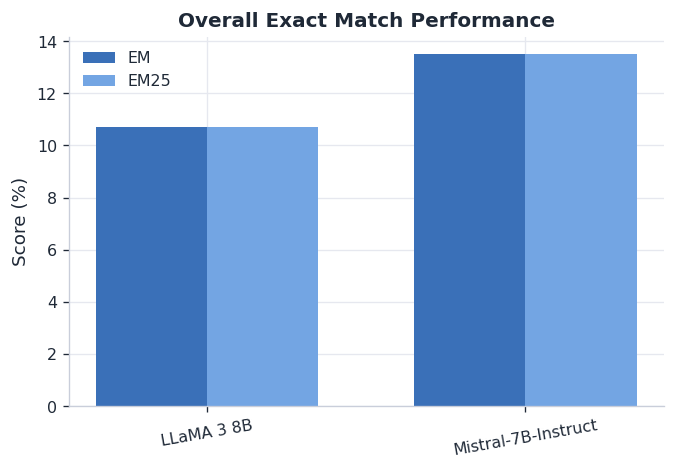

Saved: arabicaqa_rag_results/predictions\plot_overall_em_em25.png


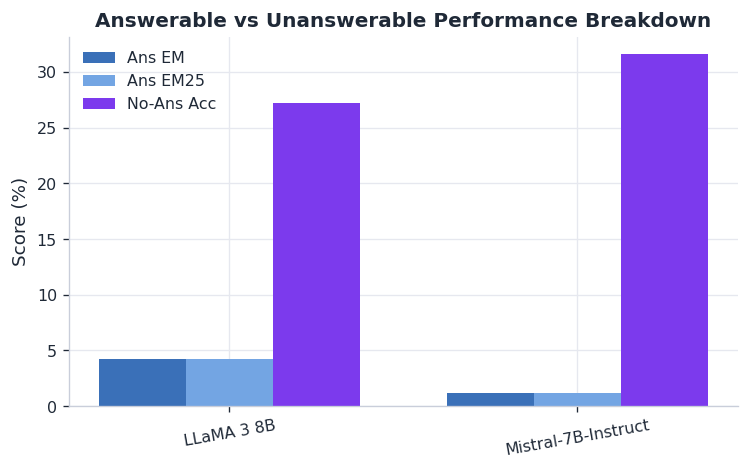

Saved: arabicaqa_rag_results/predictions\plot_breakdown_answerable_noanswer.png


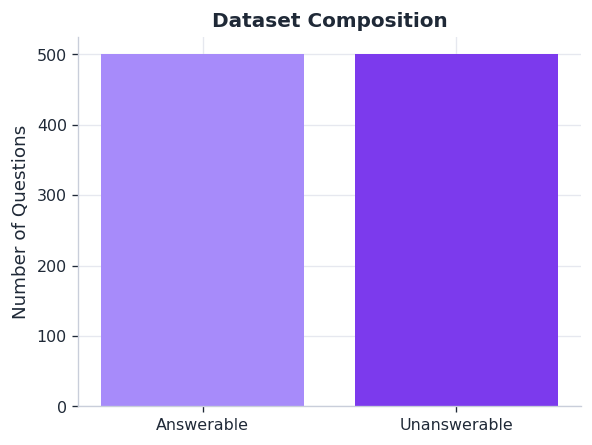

Saved: arabicaqa_rag_results/predictions\plot_dataset_split.png


In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ====== Theme colors ======
PRIMARY   = "#3A70B8"   # Blue
SECONDARY = "#73A5E3"   # Light Blue
ACCENT1   = "#A78BFA"   # Light Purple
ACCENT2   = "#7C3AED"   # Purple
GRID      = "#E6E8EF"
SPINE     = "#C9CEDA"
TXT       = "#1F2937"

# =========================
# Global theme (consistent)
# =========================
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": SPINE,
    "axes.labelcolor": TXT,
    "xtick.color": TXT,
    "ytick.color": TXT,
    "text.color": TXT,
    "axes.titleweight": "bold",
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9.5,
    "ytick.labelsize": 9.5,
    "legend.fontsize": 9.5,
    "axes.grid": True,
    "grid.color": GRID,
    "grid.linewidth": 0.8,
    "grid.alpha": 1.0,
})

# =========================
# Results (from your output)
# =========================
RESULTS = {
    "overall": {
        "LLaMA 3 8B": {"EM": 10.70, "EM25": 10.70},
        "Mistral-7B-Instruct": {"EM": 13.50, "EM25": 13.50},
    },
    "breakdown": {
        "LLaMA 3 8B": {"Ans EM": 4.20, "Ans EM25": 4.20, "No-Ans Acc": 27.20},
        "Mistral-7B-Instruct": {"Ans EM": 1.20, "Ans EM25": 1.20, "No-Ans Acc": 31.60},
    },
    "counts": {"Answerable": 500, "Unanswerable": 500},
}

OUT_DIR = "arabicaqa_rag_results/predictions"
os.makedirs(OUT_DIR, exist_ok=True)

def finalize(ax):
    ax.set_axisbelow(True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_color(SPINE)
    ax.spines["bottom"].set_color(SPINE)

def savefig(fig, path):
    fig.tight_layout()
    fig.savefig(path, dpi=300, bbox_inches="tight")
    print("Saved:", path)
    plt.close(fig)

# ======================================================
# 1) Overall EM / EM25
# ======================================================
models = list(RESULTS["overall"].keys())
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(6.4, 4.0))
ax.bar(x - width/2, [RESULTS["overall"][m]["EM"] for m in models],
       width=width, label="EM", color=PRIMARY)
ax.bar(x + width/2, [RESULTS["overall"][m]["EM25"] for m in models],
       width=width, label="EM25", color=SECONDARY)

ax.set_xticks(x)
ax.set_xticklabels(models, rotation=10)
ax.set_ylabel("Score (%)")
ax.set_title("Overall Exact Match Performance")
ax.legend(frameon=False)
finalize(ax)

plt.show()  # show first
savefig(fig, os.path.join(OUT_DIR, "plot_overall_em_em25.png"))

# ======================================================
# 2) Breakdown: Answerable EM / EM25 / No-Answer Accuracy
# ======================================================
metrics = ["Ans EM", "Ans EM25", "No-Ans Acc"]
colors  = [PRIMARY, SECONDARY, ACCENT2]
width = 0.25
x = np.arange(len(models))

fig, ax = plt.subplots(figsize=(7.2, 4.0))
for i, (metric, color) in enumerate(zip(metrics, colors)):
    ax.bar(
        x + (i - 1) * width,
        [RESULTS["breakdown"][m][metric] for m in models],
        width=width,
        label=metric,
        color=color
    )

ax.set_xticks(x)
ax.set_xticklabels(models, rotation=10)
ax.set_ylabel("Score (%)")
ax.set_title("Answerable vs Unanswerable Performance Breakdown")
ax.legend(loc="upper left", frameon=False)
finalize(ax)

plt.show()
savefig(fig, os.path.join(OUT_DIR, "plot_breakdown_answerable_noanswer.png"))

# ======================================================
# 3) Dataset split (Answerable vs Unanswerable)
# ======================================================
labels = list(RESULTS["counts"].keys())
values = list(RESULTS["counts"].values())

fig, ax = plt.subplots(figsize=(5.4, 4.0))
ax.bar(labels, values, color=[ACCENT1, ACCENT2])
ax.set_ylabel("Number of Questions")
ax.set_title("Dataset Composition")
finalize(ax)

plt.show()
savefig(fig, os.path.join(OUT_DIR, "plot_dataset_split.png"))


In [4]:
import ast
import pandas as pd

path = "arabicaqa_rag_results/predictions/"

df = pd.read_csv(path+"comparison_llama_vs_mistral_1000.csv", encoding="utf-8")

print(df.shape)
df.head(3)

def parse_correct_answers(x):
    if pd.isna(x) or x is None:
        return []
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        s = x.strip()
        # common case: "['...']"
        try:
            parsed = ast.literal_eval(s)
            if isinstance(parsed, list):
                return [str(v).strip() for v in parsed if str(v).strip()]
            # if it's a single value, wrap it
            return [str(parsed).strip()] if str(parsed).strip() else []
        except Exception:
            # fallback: treat whole string as one answer
            return [s] if s else []
    return []

df["correct_answers"] = df["correct_answers"].apply(parse_correct_answers)

# verify
print(df["correct_answers"].apply(type).value_counts())
print(df["correct_answers"].head(3))

df.to_csv(
    path+"comparison_llama_vs_mistral_1000_clean.csv",
    index=False,
    encoding="utf-8-sig"
)

df_clean = pd.read_csv(path+"comparison_llama_vs_mistral_1000_clean.csv", encoding="utf-8")

df_clean["correct_answers"] = df_clean["correct_answers"].apply(parse_correct_answers)
print(df_clean["correct_answers"].apply(type).value_counts())


print(df_clean.shape)
df_clean.head(3)

(1000, 11)
correct_answers
<class 'list'>    1000
Name: count, dtype: int64
0       [عام 2000]
1     [سبع حفريات]
2    [كصانع ألعاب]
Name: correct_answers, dtype: object
correct_answers
<class 'list'>    1000
Name: count, dtype: int64
(1000, 11)


,row_idx,split,document_id,question_id,question,context,correct_answers,is_impossible,is_answerable,predicted_answer_llama,predicted_answer_mistral
0,0,train,1732461,1193607,متي تم بناء الموقع الأول لشركة توب غولف؟,توب غولف هي شركة ترفيهية رياضية عالمية مقرها ف...,[عام 2000],False,True,غير موجود في السياق.,غير موجود في السياق.
1,1,test,1583712,1160774,كم عدد الحفريات التي تم اكتشافها لببر نغاندونغ؟,ببر نغاندونغ هو نويع منقرض من أنواع الببور الح...,[سبع حفريات],False,True,21,21 مقبرة تم اكتشافها لببر نغاندونغ.
2,2,train,1718678,1164879,ما هو مركز اللاعب ميو تساكتاش؟,ميو تساكتاش (8 مايو 1992 في سبليت في كرواتيا -...,[كصانع ألعاب],False,True,مركز اللاعب ميو تساكتاش هو مركز اللاعب في لعبة...,غير موجود في السياق.


## **RAGAS Part**

In [ ]:
import os
import ast
import math
import pandas as pd
from tqdm import tqdm

from ragas import evaluate
from datasets import Dataset
from langchain_community.llms import Ollama
from langchain_community.embeddings import HuggingFaceEmbeddings

# ====================== PATHS ======================
PRED_PATH = "arabicaqa_rag_results/predictions/comparison_llama_vs_mistral_1000.csv"
OUTPUT_DIR = "arabicaqa_rag_results/ragas_full"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ====================== LOAD CSV ======================
df_results = pd.read_csv(PRED_PATH, encoding="utf-8")
print("Loaded:", df_results.shape)

# ====================== FIX correct_answers (string -> list[str]) ======================
def parse_correct_answers(x):
    if x is None:
        return []
    if isinstance(x, float) and math.isnan(x):
        return []
    if isinstance(x, list):
        return [str(v).strip() for v in x if str(v).strip()]
    if isinstance(x, str):
        s = x.strip()
        try:
            parsed = ast.literal_eval(s)  # handles "['عام 2000']"
            if isinstance(parsed, list):
                return [str(v).strip() for v in parsed if str(v).strip()]
            return [str(parsed).strip()] if str(parsed).strip() else []
        except Exception:
            return [s] if s else []
    return []

df_results["correct_answers"] = df_results["correct_answers"].apply(parse_correct_answers)

print("correct_answers types:")
print(df_results["correct_answers"].apply(type).value_counts())
print("Example correct_answers:", df_results["correct_answers"].iloc[0])

# ========================================================================
import ragas.metrics as rm

# ---- pick metrics that exist in YOUR ragas version ----
answer_relevancy   = getattr(rm, "answer_relevancy", None)
faithfulness       = getattr(rm, "faithfulness", None)
context_recall     = getattr(rm, "context_recall", None)
context_precision  = getattr(rm, "context_precision", None)

# this one differs by version:
# some versions: context_relevancy
# others: context_relevance
context_relevancy  = getattr(rm, "context_relevancy", None) or getattr(rm, "context_relevance", None)

answer_correctness = getattr(rm, "answer_correctness", None)
answer_similarity  = getattr(rm, "answer_similarity", None)

# Build the list safely (skip missing ones)
metrics = [
    m for m in [
        answer_relevancy,
        faithfulness,
        context_recall,
        context_precision,
        context_relevancy,
        answer_correctness,
        answer_similarity
    ] if m is not None
]

print("✅ Metrics that will run:", [m.name for m in metrics])

# ====================== CONFIGURATION ======================
RUN_MODEL = 3
# 1 = llama only
# 2 = mistral only
# 3 = both

TOP_K = 5  # how many docs to keep if you need to re-retrieve contexts

# ====================== CONTEXTS ======================
# If you already have retrieved_contexts column, we use it.
# Otherwise we retrieve via your existing retriever object.
if "retrieved_contexts" not in df_results.columns:
    print("No retrieved_contexts found -> retrieving contexts now...")
    contexts_list = []
    for q in tqdm(df_results["question"].tolist(), desc="Retrieving contexts"):
        docs = retriever.invoke(q)  # assumes your retriever exists
        contexts_list.append([d.page_content for d in docs[:TOP_K]])
    df_results["retrieved_contexts"] = contexts_list

# Safety: ensure contexts are list[list[str]]
def normalize_contexts(x):
    if x is None:
        return [""]
    if isinstance(x, str):
        return [x]
    if isinstance(x, list):
        if len(x) == 0:
            return [""]
        return [str(c) for c in x]
    return [str(x)]

df_results["retrieved_contexts"] = df_results["retrieved_contexts"].apply(normalize_contexts)

# ====================== EMBEDDINGS + LOCAL JUDGE ======================
embeddings = HuggingFaceEmbeddings(model_name="intfloat/multilingual-e5-large")

from langchain_community.chat_models import ChatOllama

llm_ragas = ChatOllama(
    model="gemma2:2b",
    temperature=0.0,
    base_url="http://127.0.0.1:11434",
    format="json",          # <-- critical
)


# ====================== WHICH MODELS ======================
if RUN_MODEL == 1:
    models_to_run = ["llama"]
elif RUN_MODEL == 2:
    models_to_run = ["mistral"]
else:
    models_to_run = ["llama", "mistral"]

# ====================== RUN EVALUATION ======================
all_rows = []   # aggregated metric results
nan_rows = []   # NaN diagnostics per metric

# ====================== SPLIT DATA ======================
df_answerable   = df_results[df_results["is_answerable"] == True].copy()
df_unanswerable = df_results[df_results["is_answerable"] == False].copy()

print("Answerable:", df_answerable.shape)
print("Unanswerable:", df_unanswerable.shape)

for model_name in models_to_run:
    for tag, df_eval in [
        ("ANSWERABLE", df_answerable),
        ("UNANSWERABLE", df_unanswerable),
    ]:
        if len(df_eval) == 0:
            continue

        print(f"\nRunning RAGAS for {model_name.upper()} [{tag}]")

        if model_name == "llama":
            answers = df_eval["predicted_answer_llama"].fillna("").astype(str).tolist()
        else:
            answers = df_eval["predicted_answer_mistral"].fillna("").astype(str).tolist()

        ground_truth = df_eval["correct_answers"].apply(
            lambda x: x[0] if isinstance(x, list) and len(x) > 0 else ""
        ).tolist()

        ragas_dataset = Dataset.from_dict({
            "question": df_eval["question"].fillna("").astype(str).tolist(),
            "answer": answers,
            "contexts": df_eval["retrieved_contexts"].tolist(),
            "ground_truth": ground_truth
        })

        result = evaluate(
            ragas_dataset,
            metrics=metrics,
            llm=llm_ragas,
            embeddings=embeddings,
            raise_exceptions=False
        )

        df_scores = result.to_pandas()

        # ---- prepare row ----
        row = {
            "model": model_name.upper(),
            "subset": tag,
            "n_questions": len(df_eval),
        }

        # ---- NaN diagnostics + safe numeric aggregation ----
        numeric_df = df_scores.select_dtypes(include="number")

        # If no numeric metrics detected, try coercion
        if numeric_df.shape[1] == 0:
            for c in df_scores.columns:
                if c in ["question", "answer", "contexts", "ground_truth"]:
                    continue
                df_scores[c] = pd.to_numeric(df_scores[c], errors="coerce")
            numeric_df = df_scores.select_dtypes(include="number")

        nan_report = numeric_df.isna().sum()
        if nan_report.sum() > 0:
            print("⚠️ NaN diagnostics (failed questions per metric):")
            for k, v in nan_report.items():
                if v > 0:
                    print(f"  - {k}: {v} / {len(df_scores)}")
        else:
            print("✅ No NaNs detected in numeric metrics")

        # ---- store NaN diagnostics for saving ----
        for metric_name, nan_count in nan_report.items():
            nan_rows.append({
                "model": model_name.upper(),
                "subset": tag,
                "metric": metric_name,
                "nan_count": int(nan_count),
                "n_questions": int(len(df_scores)),
                "nan_ratio": float(nan_count / len(df_scores)) if len(df_scores) > 0 else 0.0
            })

        # ---- aggregate means safely ----
        for c in numeric_df.columns:
            row[c] = float(numeric_df[c].mean(skipna=True))

        all_rows.append(row)

    print(f"\n{model_name.upper()} DONE!")

# ====================== SAVE & DISPLAY RESULTS (NO TIMESTAMP) ======================
final_df = pd.DataFrame(all_rows)

cols = ["model", "subset", "n_questions"] + [
    c for c in final_df.columns if c not in ["model", "subset", "n_questions"]
]
final_df = final_df[cols]

csv_path  = f"{OUTPUT_DIR}/ragas_full_results.csv"
json_path = f"{OUTPUT_DIR}/ragas_full_results.json"
md_path   = f"{OUTPUT_DIR}/RAGAS_RESULTS.md"

final_df.to_csv(csv_path, index=False, encoding="utf-8-sig")
final_df.to_json(json_path, orient="records", force_ascii=False, indent=2)

with open(md_path, "w", encoding="utf-8") as f:
    f.write("# RAGAS Full Evaluation Results\n\n")
    f.write("Judge: gemma2:2b (Ollama)\n")
    f.write(f"Models: {', '.join([m.upper() for m in models_to_run])}\n\n")

    try:
        md = final_df.round(4).to_markdown(index=False)
        f.write(md)
    except Exception:
        # fallback: plain text table
        f.write(final_df.round(4).to_string(index=False))

print("\n" + "="*100)
print("RAGAS FULL EVALUATION RESULTS")
print("="*100)
print(final_df.round(4).to_string(index=False))
print("="*100)
print("Saved:")
print(f"  CSV  -> {csv_path}")
print(f"  JSON -> {json_path}")
print(f"  MD   -> {md_path}")

# ====================== SAVE NaN DIAGNOSTICS (NO TIMESTAMP) ======================
nan_df = pd.DataFrame(nan_rows)

nan_csv  = f"{OUTPUT_DIR}/ragas_nan_report.csv"
nan_json = f"{OUTPUT_DIR}/ragas_nan_report.json"

if not nan_df.empty:
    nan_df = nan_df.sort_values(["model", "subset", "metric"])

    nan_df.to_csv(nan_csv, index=False, encoding="utf-8-sig")
    nan_df.to_json(nan_json, orient="records", force_ascii=False, indent=2)

    print(f"  NaN CSV  -> {nan_csv}")
    print(f"  NaN JSON -> {nan_json}")
else:
    print("No NaN diagnostics to save.")


Loaded: (1000, 11)
correct_answers types:
correct_answers
<class 'list'>    1000
Name: count, dtype: int64
Example correct_answers: ['عام 2000']
✅ Metrics that will run: ['answer_relevancy', 'faithfulness', 'context_recall', 'context_precision', 'answer_correctness', 'answer_similarity']
No retrieved_contexts found -> retrieving contexts now...


Retrieving contexts: 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 74.30it/s]
/tmp/ipykernel_7453/4126283420.py:116: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the `langchain-ollama package and should be used instead. To use it run `pip install -U `langchain-ollama` and import as `from `langchain_ollama import ChatOllama``.
  llm_ragas = ChatOllama(


Answerable: (500, 12)
Unanswerable: (500, 12)

Running RAGAS for LLAMA [ANSWERABLE]


Evaluating:  15%|██████████                                                        | 458/3000 [30:13<3:17:20,  4.66s/it]Exception raised in Job[429]: OutputParserException(Invalid json output: The provided context discusses the National Shiftechenko Prize, which is a prize awarded to scientists who have made significant contributions to oceanography. It does not mention the specific name of the award or its purpose. The question asks for information about the 'جائزة شيفتشينكو الوطنية', which translates to 'National Shiftechenko Prize'.
For troubleshooting, visit: https://docs.langchain.com/oss/python/langchain/errors/OUTPUT_PARSING_FAILURE )
Evaluating:  16%|██████████▎                                                       | 470/3000 [30:57<2:18:28,  3.28s/it]Exception raised in Job[453]: OutputParserException(Invalid json output: The provided context discusses a French music band called 'Water Zither' and does not contain information about the person 'Laslo Sotch'.
For troubleshooting

⚠️ NaN diagnostics (failed questions per metric):
  - answer_relevancy: 1 / 500
  - faithfulness: 5 / 500
  - context_recall: 8 / 500
  - context_precision: 29 / 500
  - answer_correctness: 12 / 500

Running RAGAS for LLAMA [UNANSWERABLE]


Evaluating:   0%|                                                                    | 4/3000 [00:07<1:35:02,  1.90s/it]Exception raised in Job[0]: TimeoutError()
Exception raised in Job[1]: TimeoutError()
Exception raised in Job[2]: TimeoutError()
Exception raised in Job[3]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[6]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[9]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Evaluating:   0%|                                                                   | 5/3000 [03:00<48:28:55, 58.28s/it]Exception raised in Job[12]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[14]: TimeoutError()
Exception raised in Job[15]: TimeoutError()
Evaluating:  16%|██████████▌                                                       | 481/3000 [34:27<2:33:52,  3.67s/it]Prompt fix_output_format failed to parse output: The output parser failed to

⚠️ NaN diagnostics (failed questions per metric):
  - answer_relevancy: 4 / 500
  - faithfulness: 22 / 500
  - context_recall: 52 / 500
  - context_precision: 47 / 500
  - answer_correctness: 19 / 500

LLAMA DONE!

Running RAGAS for MISTRAL [ANSWERABLE]


Evaluating:   3%|█▊                                                                 | 81/3000 [05:31<3:35:03,  4.42s/it]Exception raised in Job[57]: OutputParserException(Invalid json output: The provided context discusses the political landscape of Tunisia, specifically mentioning a coalition of democratic forces and President Qais Saeed's actions. It does not provide information about the nature of the 'حركة اللجان الثورية'. The answer focuses on the formation of a coalition of democratic forces and their stance on President Qais Saeed's actions.
For troubleshooting, visit: https://docs.langchain.com/oss/python/langchain/errors/OUTPUT_PARSING_FAILURE )
Evaluating:  15%|██████████                                                        | 460/3000 [31:35<1:46:15,  2.51s/it]Exception raised in Job[447]: TimeoutError()
Exception raised in Job[448]: TimeoutError()
Evaluating:  16%|██████████▎                                                       | 471/3000 [32:24<3:46:54,  5.38s/it]Excepti

⚠️ NaN diagnostics (failed questions per metric):
  - answer_relevancy: 1 / 500
  - faithfulness: 25 / 500
  - context_recall: 12 / 500
  - context_precision: 49 / 500
  - answer_correctness: 28 / 500

Running RAGAS for MISTRAL [UNANSWERABLE]


Evaluating:   0%|                                                                    | 4/3000 [00:07<1:23:43,  1.68s/it]

In [9]:
# ====================== SAVE PER-QUESTION SCORES ======================
perq_path = f"{OUTPUT_DIR}/ragas_per_question_{model_name}_{tag}.csv"

df_scores.insert(0, "model", model_name.upper())
df_scores.insert(1, "subset", tag)

df_scores.to_csv(perq_path, index=False, encoding="utf-8-sig")
print(f"  Per-question CSV -> {perq_path}")


  Per-question CSV -> arabicaqa_rag_results/ragas_full/ragas_per_question_mistral_UNANSWERABLE.csv


The experiments were executed on Lambda Cloud using a single NVIDIA A100 GPU, with long-running jobs managed via terminal session multiplexing (tmux) to ensure uninterrupted execution in the event of network or SSH disconnections.

The total session duration was approximately 15 hours and 59 minutes, of which 14–15 hours were dedicated to running the RAGAS evaluation pipeline, while the remaining time was used for environment setup and code execution on the Lambda instance. During the final 1–2 hours of execution, the internet connection was interrupted, which prevented the outputs from appearing in the interactive notebook interface. However, since the experiment was running inside a tmux session, the Lambda server successfully completed the execution and all results were generated and saved correctly.

Loaded results: (4, 9)
  model       subset  n_questions  answer_relevancy  faithfulness  context_recall  context_precision  answer_correctness  answer_similarity
  LLAMA   ANSWERABLE          500            0.5866        0.8111          0.6087             0.2386              0.5820             0.8396
  LLAMA UNANSWERABLE          500            0.6758        0.7993          0.8991             0.0480              0.5057             0.7497
MISTRAL   ANSWERABLE          500            0.5027        0.8614          0.6096             0.2309              0.5218             0.8231
MISTRAL UNANSWERABLE          500            0.6078        0.8381          0.9054             0.0476              0.4899             0.7401

Loaded NaN report: (24, 6)
model       subset             metric  nan_count  n_questions  nan_ratio
LLAMA   ANSWERABLE answer_correctness         12          500      0.024
LLAMA   ANSWERABLE   answer_relevancy          1          500      0.002
LLAMA   ANSWERABLE  answer_sim

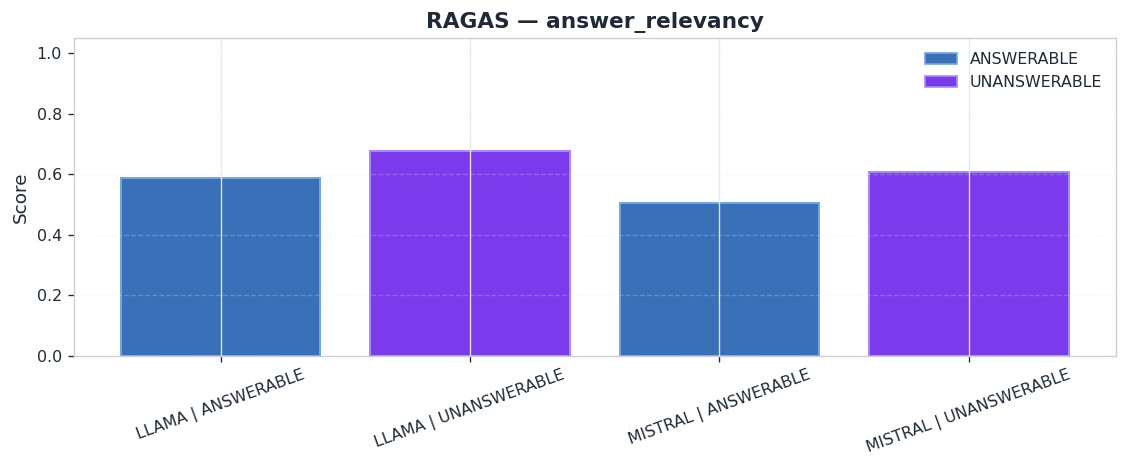

Saved → arabicaqa_rag_results/ragas_full\figures\ragas_answer_relevancy.png


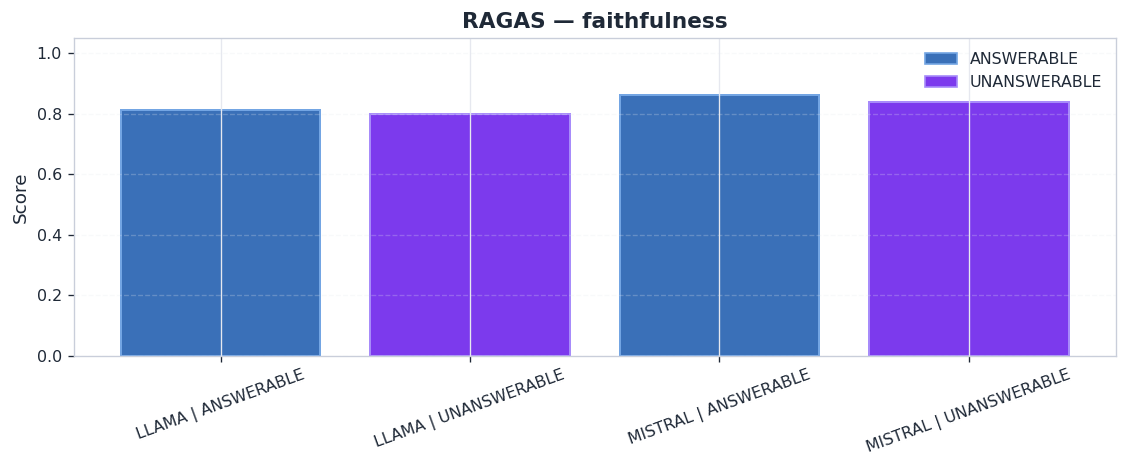

Saved → arabicaqa_rag_results/ragas_full\figures\ragas_faithfulness.png


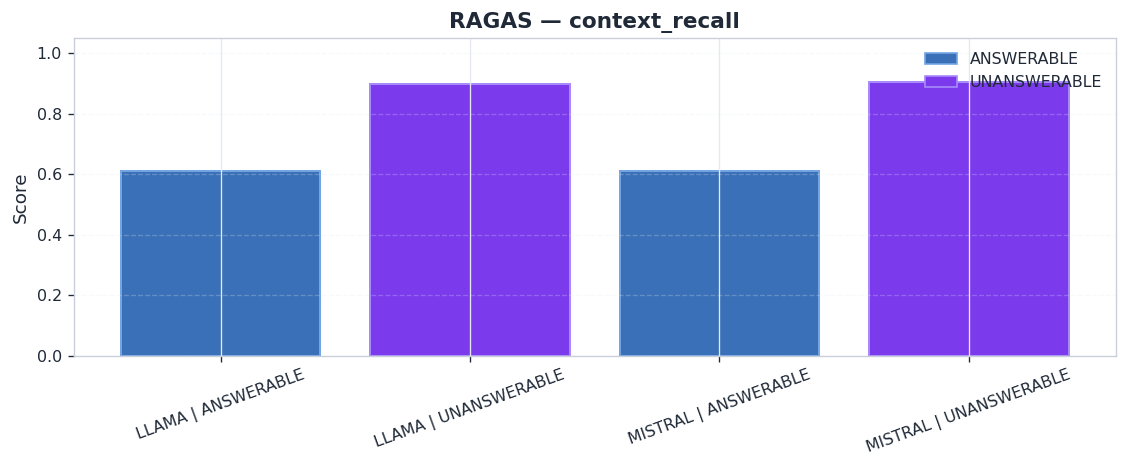

Saved → arabicaqa_rag_results/ragas_full\figures\ragas_context_recall.png


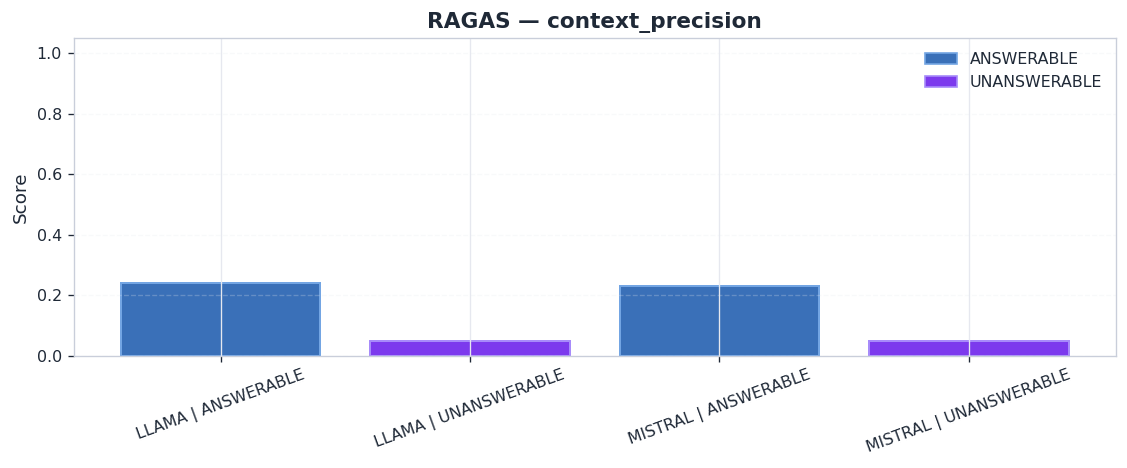

Saved → arabicaqa_rag_results/ragas_full\figures\ragas_context_precision.png


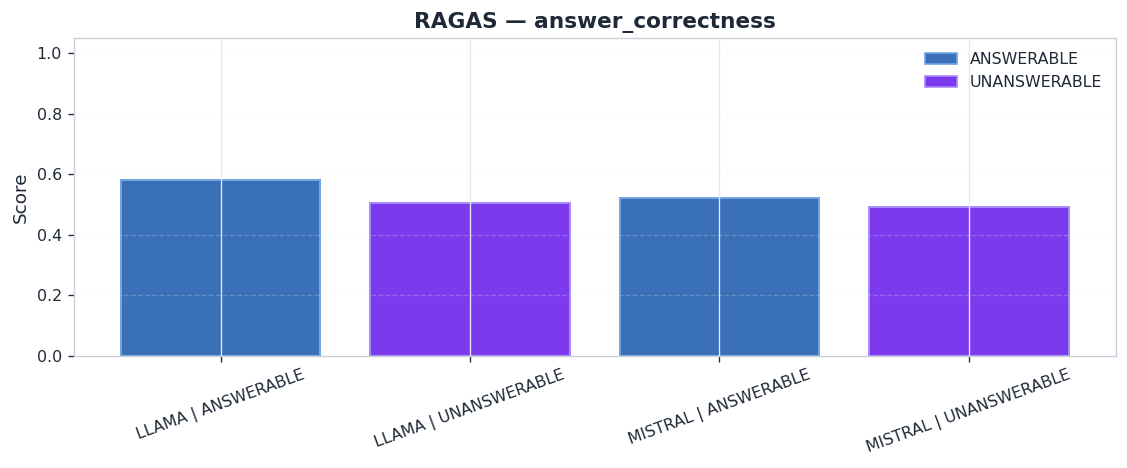

Saved → arabicaqa_rag_results/ragas_full\figures\ragas_answer_correctness.png


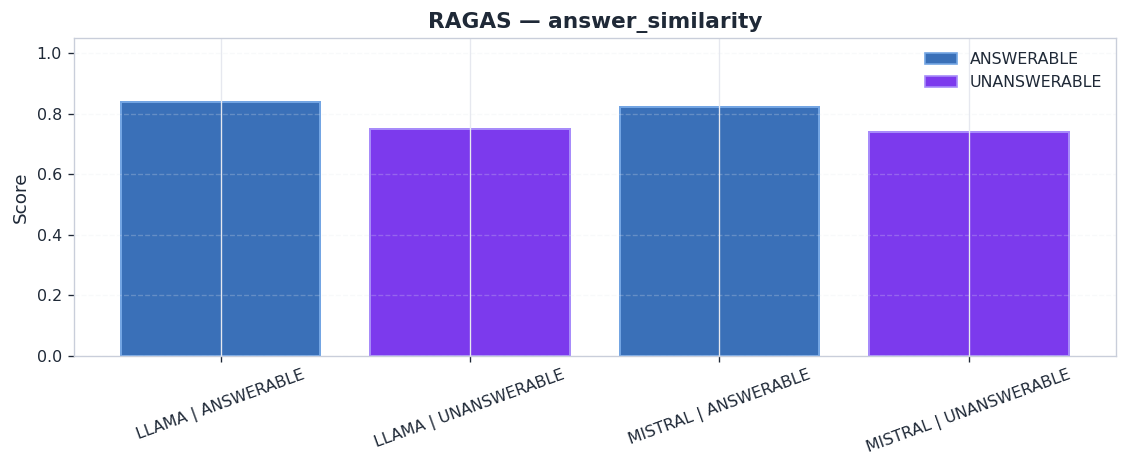

Saved → arabicaqa_rag_results/ragas_full\figures\ragas_answer_similarity.png


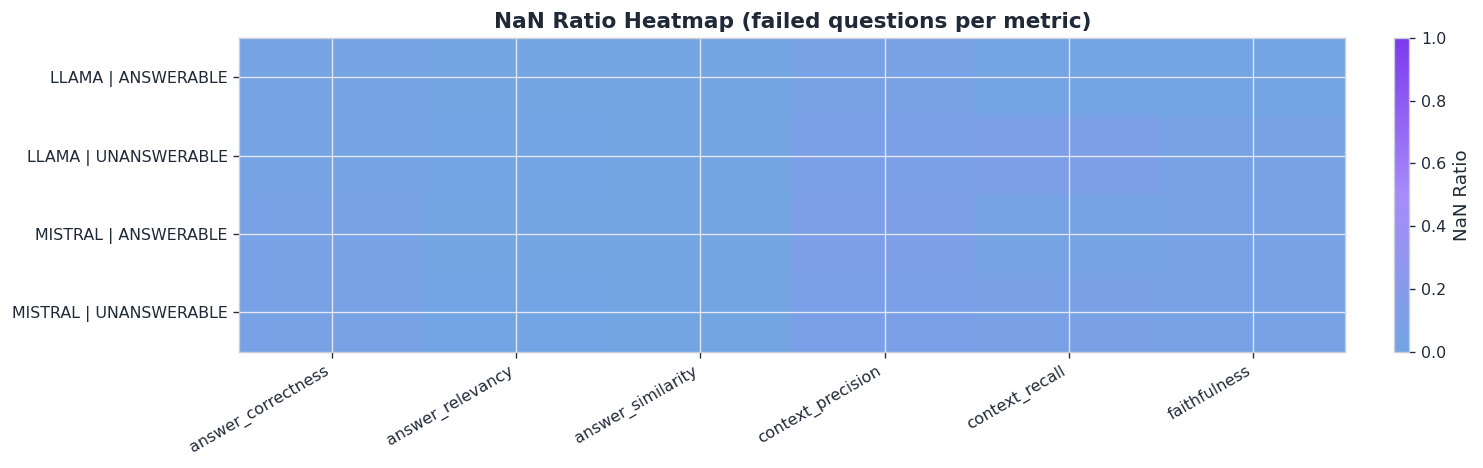

Saved → arabicaqa_rag_results/ragas_full\figures\ragas_nan_heatmap.png


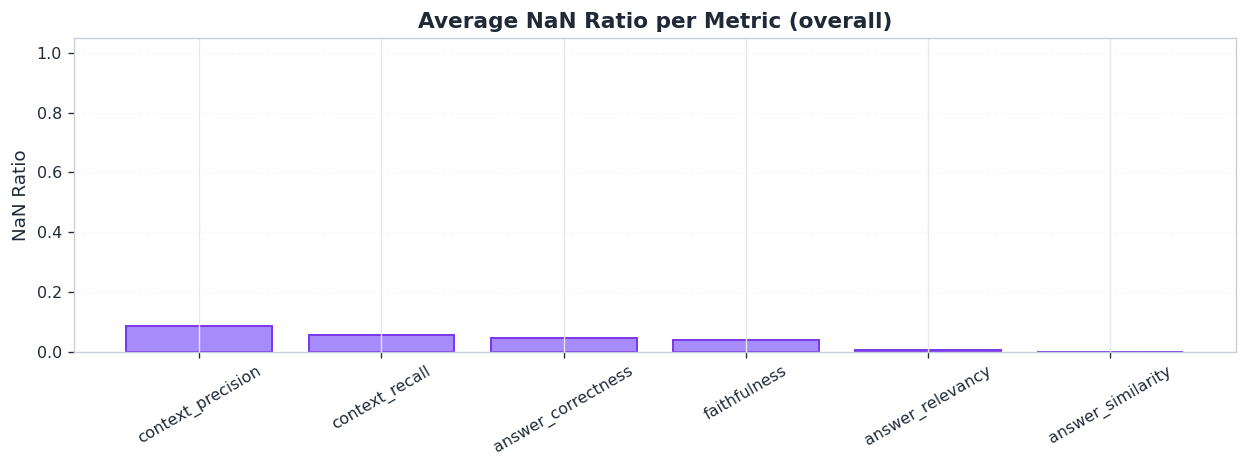

Saved → arabicaqa_rag_results/ragas_full\figures\ragas_nan_ratio_summary.png

Done ✅ Figures saved in: arabicaqa_rag_results/ragas_full\figures


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

OUTPUT_DIR = "arabicaqa_rag_results/ragas_full"
res_path = os.path.join(OUTPUT_DIR, "ragas_full_results.csv")
nan_path = os.path.join(OUTPUT_DIR, "ragas_nan_report.csv")

# ======================
# 0) FIGURES DIR
# ======================
FIG_DIR = os.path.join(OUTPUT_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)

# ======================
# 1) LOAD
# ======================
df = pd.read_csv(res_path, encoding="utf-8")
nan_df = pd.read_csv(nan_path, encoding="utf-8") if os.path.exists(nan_path) else None

print("Loaded results:", df.shape)
print(df.round(4).to_string(index=False))

if nan_df is not None:
    print("\nLoaded NaN report:", nan_df.shape)
    print(nan_df.head(10).to_string(index=False))

# ====== Theme colors ======
PRIMARY   = "#3A70B8"   # Blue
SECONDARY = "#73A5E3"   # Light Blue
ACCENT1   = "#A78BFA"   # Light Purple
ACCENT2   = "#7C3AED"   # Purple

# Apply a light global style (keeps your colors)
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["figure.dpi"] = 120

# ======================
# 2) PREP
# ======================
df_plot = df.copy()
df_plot["model"] = df_plot["model"].astype(str)
df_plot["subset"] = df_plot["subset"].astype(str)
df_plot["group"] = df_plot["model"] + " | " + df_plot["subset"]

id_cols = {"model", "subset", "n_questions", "group"}
metric_cols = [c for c in df_plot.columns if c not in id_cols]

# force numeric
for c in metric_cols:
    df_plot[c] = pd.to_numeric(df_plot[c], errors="coerce")

metric_cols = [c for c in metric_cols if df_plot[c].notna().any()]
print("\nMetrics columns detected:", metric_cols)

# Color mapping per subset (answerable vs unanswerable)
subset_color = {
    "ANSWERABLE": PRIMARY,
    "UNANSWERABLE": ACCENT2
}

bar_colors = [subset_color.get(s, SECONDARY) for s in df_plot["subset"].tolist()]
edge_colors = [SECONDARY if s == "ANSWERABLE" else ACCENT1 for s in df_plot["subset"].tolist()]

# ======================
# 3) PLOT A: One bar chart per metric (colored by subset) + SAVE
# ======================
for metric in metric_cols:
    fig, ax = plt.subplots(figsize=(9.5, 4))

    values = df_plot[metric].values
    labels = df_plot["group"].tolist()

    ax.bar(
        labels,
        values,
        color=bar_colors,
        edgecolor=edge_colors,
        linewidth=1.2
    )

    ax.set_title(f"RAGAS — {metric}")
    ax.set_ylabel("Score")
    ax.set_ylim(0, 1.05)
    ax.tick_params(axis="x", rotation=20)
    ax.grid(axis="y", linestyle="--", alpha=0.25)

    # Legend for subset colors
    legend_items = [
        Patch(facecolor=PRIMARY, edgecolor=SECONDARY, label="ANSWERABLE"),
        Patch(facecolor=ACCENT2, edgecolor=ACCENT1, label="UNANSWERABLE")
    ]
    ax.legend(handles=legend_items, loc="upper right", frameon=False)

    plt.tight_layout()

    # Save
    safe_name = metric.replace("/", "_").replace(" ", "_")
    png_path = os.path.join(FIG_DIR, f"ragas_{safe_name}.png")
    pdf_path = os.path.join(FIG_DIR, f"ragas_{safe_name}.pdf")

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()

    print(f"Saved → {png_path}")

# ======================
# 4) PLOT B: NaN heatmap (nan_ratio) with your theme colormap + SAVE
# ======================
if nan_df is not None and not nan_df.empty:
    nan_df2 = nan_df.copy()
    nan_df2["model"] = nan_df2["model"].astype(str)
    nan_df2["subset"] = nan_df2["subset"].astype(str)
    nan_df2["metric"] = nan_df2["metric"].astype(str)
    nan_df2["group"] = nan_df2["model"] + " | " + nan_df2["subset"]

    pivot = (
        nan_df2.pivot_table(
            index="group",
            columns="metric",
            values="nan_ratio",
            aggfunc="mean"
        )
        .fillna(0.0)
    )

    # Custom colormap from SECONDARY -> ACCENT1 -> ACCENT2
    theme_cmap = LinearSegmentedColormap.from_list(
        "theme_cmap",
        [SECONDARY, ACCENT1, ACCENT2]
    )

    fig, ax = plt.subplots(figsize=(12.5, 4))
    im = ax.imshow(pivot.values, aspect="auto", cmap=theme_cmap, vmin=0, vmax=1)

    ax.set_title("NaN Ratio Heatmap (failed questions per metric)")
    ax.set_yticks(np.arange(len(pivot.index)))
    ax.set_yticklabels(pivot.index.tolist())

    ax.set_xticks(np.arange(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns.tolist(), rotation=30, ha="right")

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("NaN Ratio")

    plt.tight_layout()

    # Save
    png_path = os.path.join(FIG_DIR, "ragas_nan_heatmap.png")
    pdf_path = os.path.join(FIG_DIR, "ragas_nan_heatmap.pdf")

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()

    print(f"Saved → {png_path}")

# ======================
# 5) PLOT C: NaN ratio summary per metric (overall) + SAVE
# ======================
if nan_df is not None and not nan_df.empty:
    nan_summary = (
        nan_df.groupby("metric", as_index=False)["nan_ratio"]
        .mean()
        .sort_values("nan_ratio", ascending=False)
    )

    fig, ax = plt.subplots(figsize=(10.5, 4))
    ax.bar(
        nan_summary["metric"],
        nan_summary["nan_ratio"],
        color=ACCENT1,
        edgecolor=ACCENT2,
        linewidth=1.2
    )

    ax.set_title("Average NaN Ratio per Metric (overall)")
    ax.set_ylabel("NaN Ratio")
    ax.set_ylim(0, 1.05)
    ax.tick_params(axis="x", rotation=30)
    ax.grid(axis="y", linestyle="--", alpha=0.25)

    plt.tight_layout()

    # Save
    png_path = os.path.join(FIG_DIR, "ragas_nan_ratio_summary.png")
    pdf_path = os.path.join(FIG_DIR, "ragas_nan_ratio_summary.pdf")

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()

    print(f"Saved → {png_path}")

print("\nDone ✅ Figures saved in:", FIG_DIR)


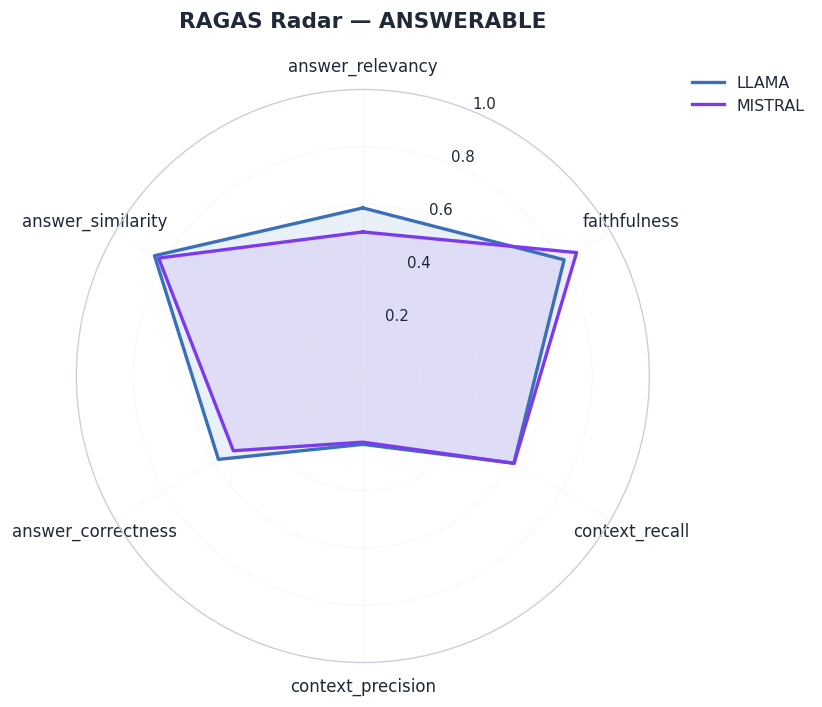

Saved → arabicaqa_rag_results/ragas_full\figures\ragas_radar_answerable.png


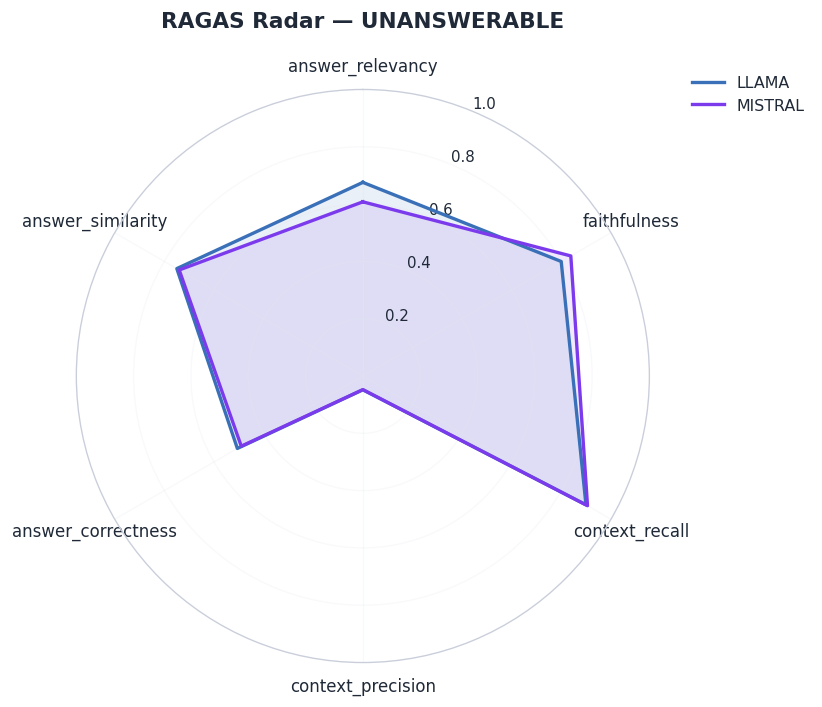

Saved → arabicaqa_rag_results/ragas_full\figures\ragas_radar_unanswerable.png


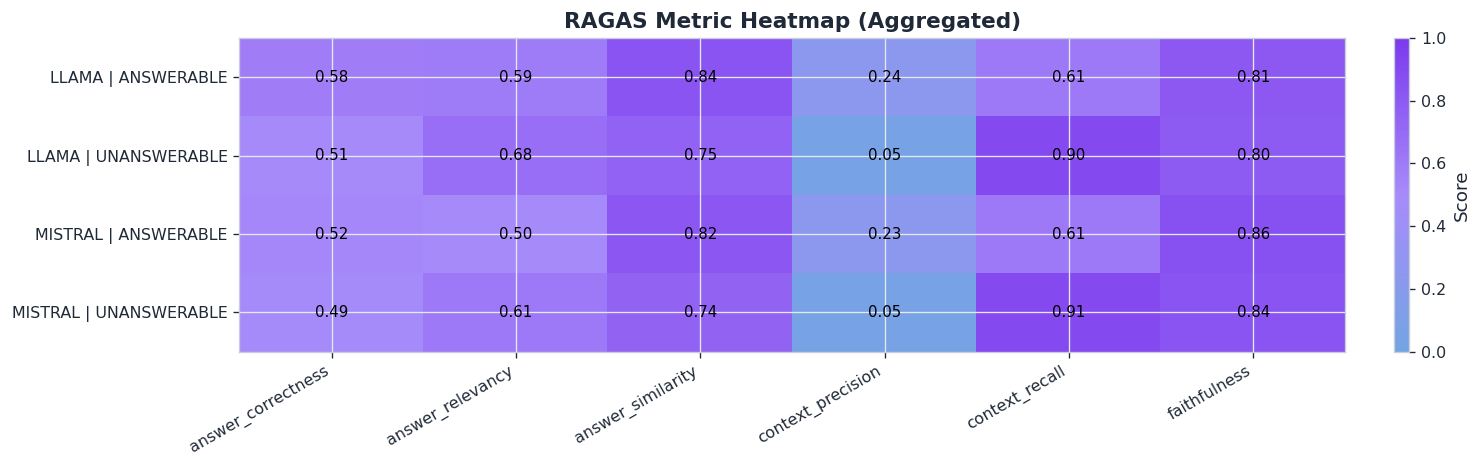

Saved → arabicaqa_rag_results/ragas_full\figures\ragas_metric_heatmap.png


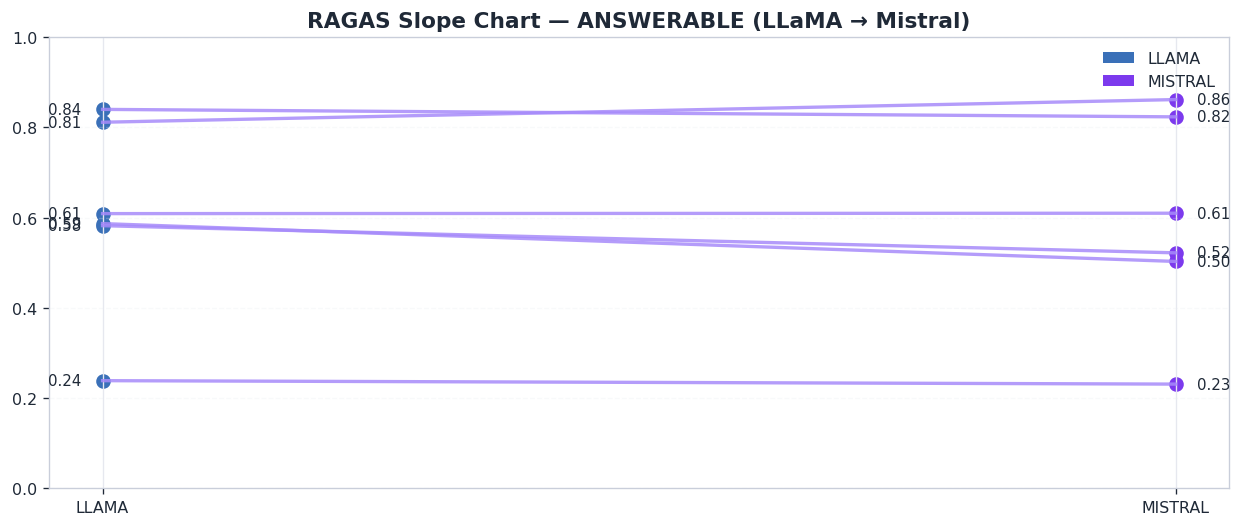

Saved → arabicaqa_rag_results/ragas_full\figures\ragas_slope_answerable.png


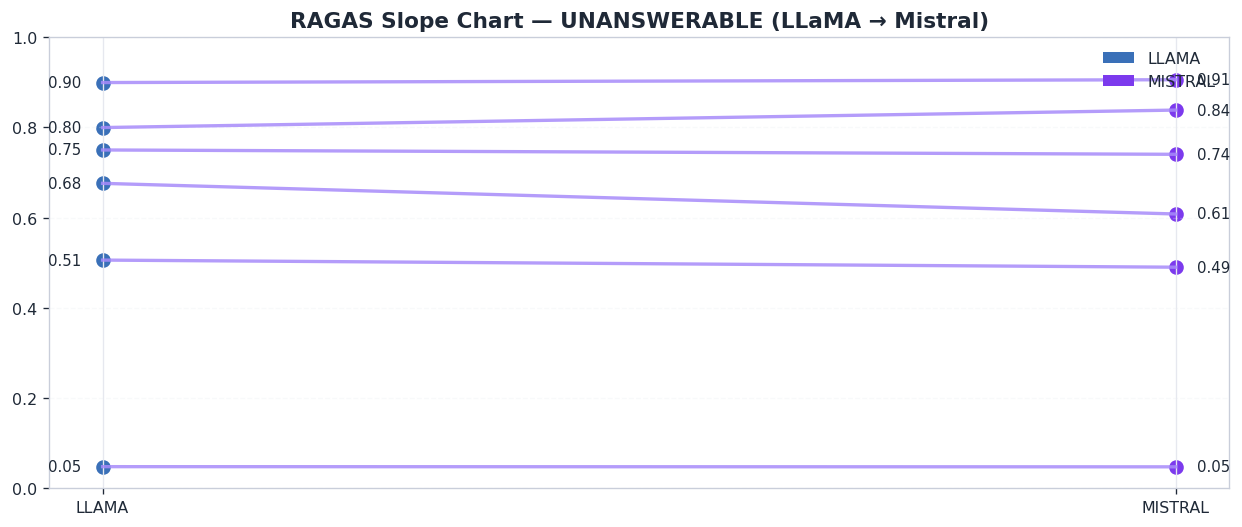

Saved → arabicaqa_rag_results/ragas_full\figures\ragas_slope_unanswerable.png


In [4]:
# ======================
# 6) PLOT D: Radar (Spider) chart — per subset (ANSWERABLE / UNANSWERABLE)
# ======================
def radar_chart_for_subset(df_plot, subset_name, metric_cols, fig_path_png, fig_path_pdf):
    sub = df_plot[df_plot["subset"].str.upper() == subset_name.upper()].copy()
    if sub.empty:
        print(f"[Radar] No rows for subset={subset_name}")
        return

    # Order metrics as given
    labels = metric_cols
    num_vars = len(labels)

    # Angles
    angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # close the loop

    fig = plt.figure(figsize=(7, 6))
    ax = plt.subplot(111, polar=True)

    # Plot each model
    for i, row in sub.iterrows():
        values = [float(row[m]) if pd.notna(row[m]) else 0.0 for m in labels]
        values += values[:1]

        color = PRIMARY if row["model"].upper().startswith("LLAMA") else ACCENT2
        ax.plot(angles, values, linewidth=2, color=color, label=row["model"])
        ax.fill(angles, values, color=color, alpha=0.10)

    ax.set_title(f"RAGAS Radar — {subset_name}", pad=18)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)

    ax.set_ylim(0, 1.0)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["0.2","0.4","0.6","0.8","1.0"], fontsize=9)
    ax.grid(alpha=0.25)

    ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1.05), frameon=False)

    plt.tight_layout()
    plt.savefig(fig_path_png, dpi=300, bbox_inches="tight")
    plt.savefig(fig_path_pdf, bbox_inches="tight")
    plt.show()
    plt.close()
    print("Saved →", fig_path_png)

radar_chart_for_subset(
    df_plot, "ANSWERABLE", metric_cols,
    os.path.join(FIG_DIR, "ragas_radar_answerable.png"),
    os.path.join(FIG_DIR, "ragas_radar_answerable.pdf"),
)
radar_chart_for_subset(
    df_plot, "UNANSWERABLE", metric_cols,
    os.path.join(FIG_DIR, "ragas_radar_unanswerable.png"),
    os.path.join(FIG_DIR, "ragas_radar_unanswerable.pdf"),
)

# ======================
# 7) PLOT E: Heatmap of metric values (group x metric)
# ======================
# Pivot: rows = model|subset, cols = metrics
val_pivot = (
    df_plot.pivot_table(index="group", values=metric_cols, aggfunc="mean")
    .reindex(df_plot["group"].tolist())  # keep original order
)

# Colormap: SECONDARY -> ACCENT1 -> ACCENT2
theme_cmap = LinearSegmentedColormap.from_list(
    "theme_cmap_vals", [SECONDARY, ACCENT1, ACCENT2]
)

fig, ax = plt.subplots(figsize=(12.5, 4))
im = ax.imshow(val_pivot.values, aspect="auto", cmap=theme_cmap, vmin=0, vmax=1)

ax.set_title("RAGAS Metric Heatmap (Aggregated)")
ax.set_yticks(np.arange(len(val_pivot.index)))
ax.set_yticklabels(val_pivot.index.tolist())

ax.set_xticks(np.arange(len(val_pivot.columns)))
ax.set_xticklabels(val_pivot.columns.tolist(), rotation=30, ha="right")

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Score")

# annotate values
for i in range(val_pivot.shape[0]):
    for j in range(val_pivot.shape[1]):
        v = val_pivot.values[i, j]
        ax.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=9, color="black")

plt.tight_layout()
png_path = os.path.join(FIG_DIR, "ragas_metric_heatmap.png")
pdf_path = os.path.join(FIG_DIR, "ragas_metric_heatmap.pdf")
plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.savefig(pdf_path, bbox_inches="tight")
plt.show()
plt.close()
print("Saved →", png_path)

# ======================
# 8) PLOT F: Slope chart (LLaMA → Mistral) per metric, split by subset
# ======================
def slope_chart(df_plot, subset_name, metric_cols, out_png, out_pdf):
    sub = df_plot[df_plot["subset"].str.upper() == subset_name.upper()].copy()
    if sub.empty:
        print(f"[Slope] No rows for subset={subset_name}")
        return

    # Expect two rows: LLAMA and MISTRAL
    sub = sub.set_index("model")
    if not (("LLAMA" in sub.index) and ("MISTRAL" in sub.index)):
        print(f"[Slope] Need both LLAMA and MISTRAL for subset={subset_name}")
        return

    llama_vals = [float(sub.loc["LLAMA", m]) for m in metric_cols]
    mistr_vals = [float(sub.loc["MISTRAL", m]) for m in metric_cols]

    x0, x1 = 0, 1
    y = np.arange(len(metric_cols))

    fig, ax = plt.subplots(figsize=(10.5, 4.5))
    for i, m in enumerate(metric_cols):
        ax.plot([x0, x1], [llama_vals[i], mistr_vals[i]], color=ACCENT1, linewidth=2, alpha=0.85)
        ax.scatter([x0], [llama_vals[i]], color=PRIMARY, s=60)
        ax.scatter([x1], [mistr_vals[i]], color=ACCENT2, s=60)

        ax.text(x0 - 0.02, llama_vals[i], f"{llama_vals[i]:.2f}", ha="right", va="center", fontsize=9)
        ax.text(x1 + 0.02, mistr_vals[i], f"{mistr_vals[i]:.2f}", ha="left", va="center", fontsize=9)

    ax.set_title(f"RAGAS Slope Chart — {subset_name} (LLaMA → Mistral)")
    ax.set_xticks([x0, x1])
    ax.set_xticklabels(["LLAMA", "MISTRAL"])
    ax.set_ylim(0, 1.0)
    ax.grid(axis="y", linestyle="--", alpha=0.25)

    # Put metric names on left side (y-axis labels)
    ax.set_yticks(np.linspace(0, 1, 6))
    # Add a legend proxy
    legend_items = [
        Patch(facecolor=PRIMARY, label="LLAMA"),
        Patch(facecolor=ACCENT2, label="MISTRAL"),
    ]
    ax.legend(handles=legend_items, loc="upper right", frameon=False)

    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.savefig(out_pdf, bbox_inches="tight")
    plt.show()
    plt.close()
    print("Saved →", out_png)

slope_chart(
    df_plot, "ANSWERABLE", metric_cols,
    os.path.join(FIG_DIR, "ragas_slope_answerable.png"),
    os.path.join(FIG_DIR, "ragas_slope_answerable.pdf"),
)
slope_chart(
    df_plot, "UNANSWERABLE", metric_cols,
    os.path.join(FIG_DIR, "ragas_slope_unanswerable.png"),
    os.path.join(FIG_DIR, "ragas_slope_unanswerable.pdf"),
)


## **EXTRA METRICS**

[Retrieval] MRR@5  = 0.396000
[Retrieval] nDCG@5 = 0.396000  (must be <= 1.0)
Generation metrics computed on answerable-only: (500, 11)

EXTRA METRICS — Retrieval@5 (all) + Generation (answerable-only)
  model  MRR@5  nDCG@5  ROUGE_L  Tok_Precision  Tok_Recall  Tok_F1 tok_pr_impl  BLEU_short  BLEU_1  BLEU_2  BLEU_4  rouge_impl    bleu_impl  n_questions_retrieval  n_questions_generation
  LLAMA  0.396   0.396   0.0833         0.1443      0.1391  0.1303   token-set      0.0612  0.1041  0.0808  0.0612 rouge-score nltk-dynamic                   1000                     500
MISTRAL  0.396   0.396   0.0673         0.0947      0.1175  0.0918   token-set      0.0298  0.0668  0.0464  0.0297 rouge-score nltk-dynamic                   1000                     500
Saved CSV : arabicaqa_rag_results/ragas_full\extra_metrics_both_shortbleu_prf.csv
Saved JSON: arabicaqa_rag_results/ragas_full\extra_metrics_both_shortbleu_prf.json


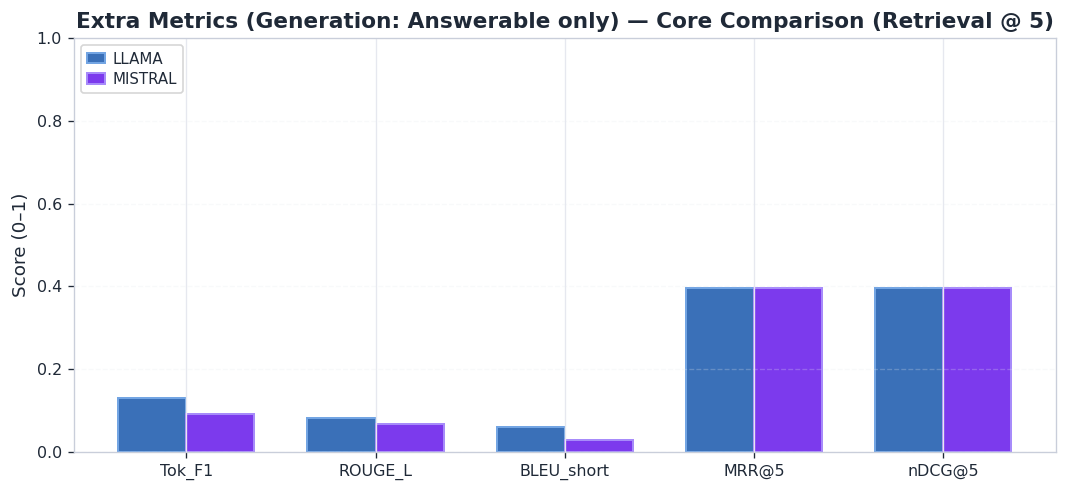

Saved: arabicaqa_rag_results/ragas_full\figures_extra\extra_core_grouped_bar.png
Saved: arabicaqa_rag_results/ragas_full\figures_extra\extra_core_grouped_bar.pdf


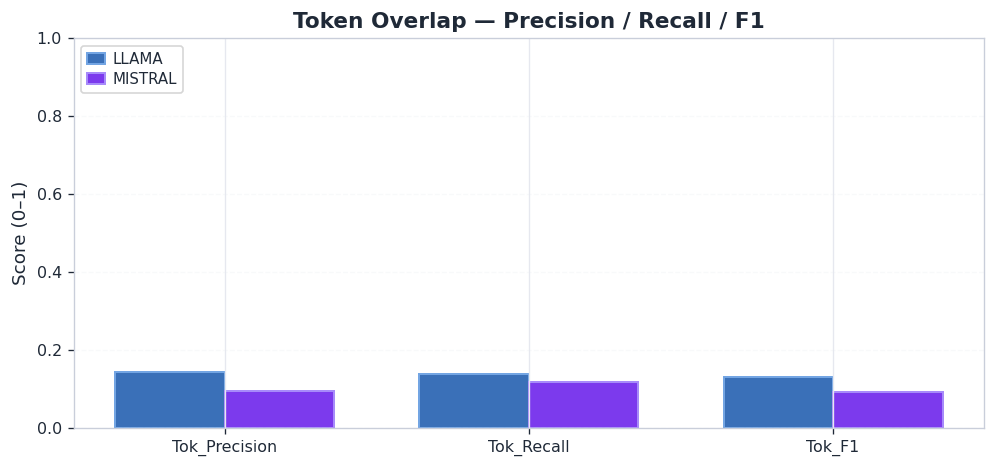

Saved: arabicaqa_rag_results/ragas_full\figures_extra\extra_token_prf_grouped_bar.png
Saved: arabicaqa_rag_results/ragas_full\figures_extra\extra_token_prf_grouped_bar.pdf


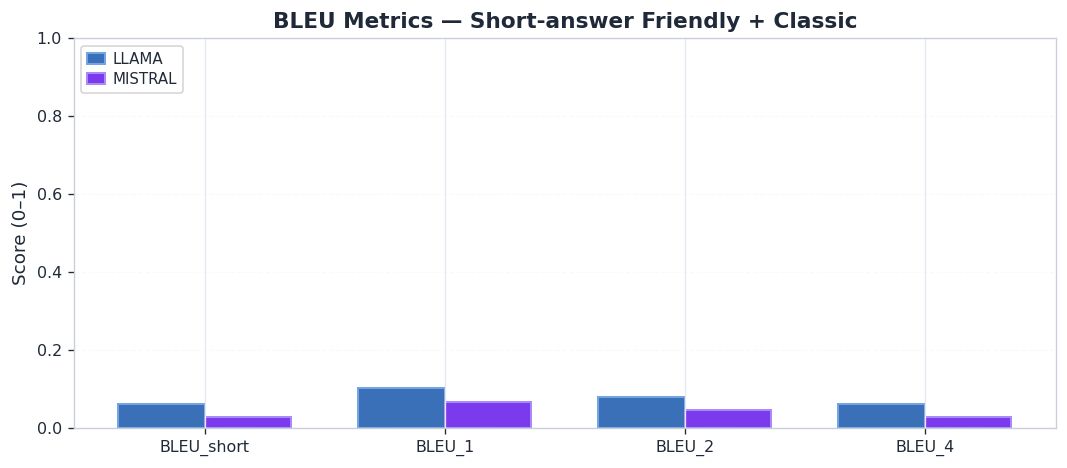

Saved: arabicaqa_rag_results/ragas_full\figures_extra\extra_bleu_grouped_bar.png
Saved: arabicaqa_rag_results/ragas_full\figures_extra\extra_bleu_grouped_bar.pdf


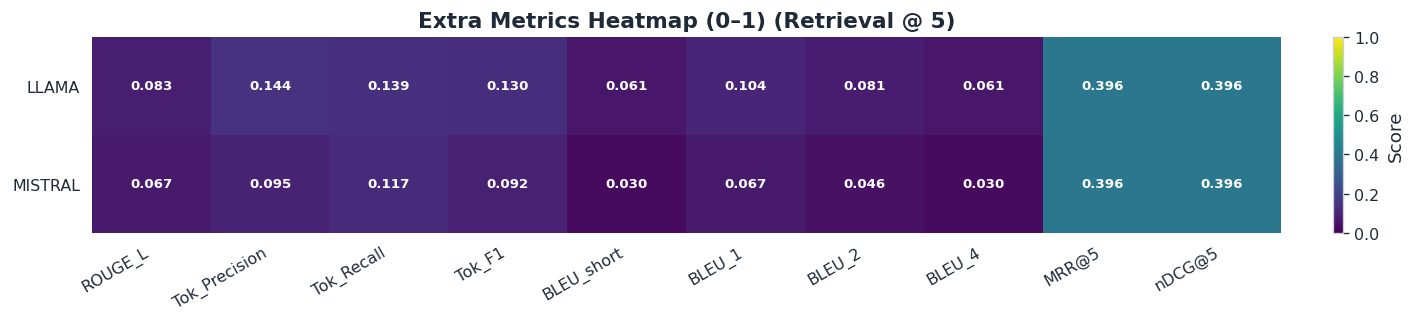

Saved: arabicaqa_rag_results/ragas_full\figures_extra\extra_metrics_heatmap.png
Saved: arabicaqa_rag_results/ragas_full\figures_extra\extra_metrics_heatmap.pdf


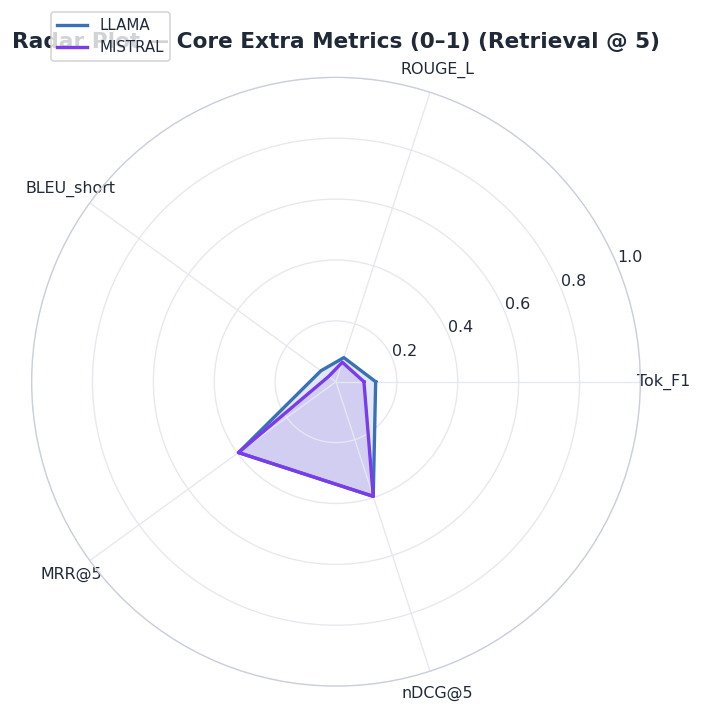

Saved: arabicaqa_rag_results/ragas_full\figures_extra\extra_core_radar.png
Saved: arabicaqa_rag_results/ragas_full\figures_extra\extra_core_radar.pdf

Done ✅ Saved CSV/JSON + all figures in: arabicaqa_rag_results/ragas_full\figures_extra


In [20]:
# ============================================================
# FULL SCRIPT: compute correct MRR@K + nDCG@K (<=1 always),
# compute generation metrics (answerable-only),
# save CSV/JSON, then plot all figures with your theme.
# ============================================================

import os
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------
# CONFIG
# -----------------------
OUTPUT_DIR = "arabicaqa_rag_results/ragas_full"
os.makedirs(OUTPUT_DIR, exist_ok=True)

CSV_PATH  = os.path.join(OUTPUT_DIR, "extra_metrics_both_shortbleu_prf.csv")
JSON_PATH = os.path.join(OUTPUT_DIR, "extra_metrics_both_shortbleu_prf.json")

FIG_DIR = os.path.join(OUTPUT_DIR, "figures_extra")
os.makedirs(FIG_DIR, exist_ok=True)

TOPK = 5  # <-- MUST match your retriever depth (top-k retrieved docs)

# ====== Theme colors (your theme) ======
PRIMARY   = "#3A70B8"
SECONDARY = "#73A5E3"
ACCENT1   = "#A78BFA"
ACCENT2   = "#7C3AED"


# ============================================================
# UTILITIES
# ============================================================
def safe_str(x):
    return "" if x is None or (isinstance(x, float) and math.isnan(x)) else str(x)

def first_ref(x):
    if isinstance(x, list) and len(x) > 0:
        return safe_str(x[0]).strip()
    return safe_str(x).strip()

def safe_int(x, default=None):
    try:
        return int(x)
    except Exception:
        return default


# ============================================================
# RETRIEVAL METRICS (CORRECT)
# ============================================================
def mrr_at_k(gold_doc_id, retrieved_doc_ids, k):
    """MRR@k with binary relevance (single gold doc)."""
    if gold_doc_id is None or not isinstance(retrieved_doc_ids, list):
        return 0.0
    retrieved_doc_ids = retrieved_doc_ids[:k]
    for i, rid in enumerate(retrieved_doc_ids):
        if rid == gold_doc_id:
            return 1.0 / (i + 1)
    return 0.0

def ndcg_at_k_single_hit(gold_doc_id, retrieved_doc_ids, k):
    """
    nDCG@k with ONE relevant document (binary relevance).
    Always in [0, 1].
    """
    if gold_doc_id is None or not isinstance(retrieved_doc_ids, list):
        return 0.0
    retrieved_doc_ids = retrieved_doc_ids[:k]
    for i, rid in enumerate(retrieved_doc_ids):
        if rid == gold_doc_id:
            # rank = i+1 => DCG = 1/log2(rank+1) = 1/log2(i+2)
            dcg = 1.0 / np.log2(i + 2)
            idcg = 1.0  # best case at rank 1 => 1/log2(2)=1
            return dcg / idcg
    return 0.0


# ============================================================
# GENERATION METRICS
# ============================================================
def compute_token_prf(df, model_col):
    """
    Token-set overlap (short-answer friendly):
      Precision = |pred ∩ ref| / |pred|
      Recall    = |pred ∩ ref| / |ref|
      F1        = harmonic mean
    """
    p_list, r_list, f1_list = [], [], []

    for _, row in df.iterrows():
        pred = safe_str(row.get(model_col, "")).strip()
        ref  = first_ref(row.get("correct_answers", []))

        pred_toks = [t for t in pred.split() if t]
        ref_toks  = [t for t in ref.split() if t]

        if len(pred_toks) == 0 and len(ref_toks) == 0:
            p_list.append(1.0); r_list.append(1.0); f1_list.append(1.0)
            continue
        if len(pred_toks) == 0 or len(ref_toks) == 0:
            p_list.append(0.0); r_list.append(0.0); f1_list.append(0.0)
            continue

        pred_set = set(pred_toks)
        ref_set  = set(ref_toks)
        inter = len(pred_set & ref_set)

        prec = inter / len(pred_set) if len(pred_set) else 0.0
        rec  = inter / len(ref_set)  if len(ref_set)  else 0.0
        f1   = (2 * prec * rec / (prec + rec)) if (prec + rec) > 0 else 0.0

        p_list.append(prec)
        r_list.append(rec)
        f1_list.append(f1)

    return float(np.mean(p_list)), float(np.mean(r_list)), float(np.mean(f1_list)), "token-set"


def compute_rouge_l(df, model_col):
    scores = []
    try:
        from rouge_score import rouge_scorer
        scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=False)

        for _, row in df.iterrows():
            pred = safe_str(row.get(model_col, "")).strip()
            ref  = first_ref(row.get("correct_answers", []))

            if ref == "" and pred == "":
                scores.append(1.0)
            elif ref == "":
                scores.append(0.0)
            else:
                scores.append(scorer.score(ref, pred)["rougeL"].fmeasure)

        return float(np.mean(scores)), "rouge-score"

    except Exception as e:
        print(f"ROUGE-L not available. ({e})")
        return float("nan"), "missing"


def compute_bleu_short(df, model_col):
    """
    BLEU for short answers:
      BLEU_short: weights depend on reference length (1..4)
      BLEU_1, BLEU_2, BLEU_4: standard variants
    """
    try:
        from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
        smoothie = SmoothingFunction().method1

        bleu_short_scores, bleu1_scores, bleu2_scores, bleu4_scores = [], [], [], []

        for _, row in df.iterrows():
            pred = safe_str(row.get(model_col, "")).strip()
            ref  = first_ref(row.get("correct_answers", []))

            pred_tokens = pred.split()
            ref_tokens  = ref.split()

            if len(ref_tokens) == 0 and len(pred_tokens) == 0:
                bleu_short_scores.append(1.0)
                bleu1_scores.append(1.0)
                bleu2_scores.append(1.0)
                bleu4_scores.append(1.0)
                continue
            if len(ref_tokens) == 0 or len(pred_tokens) == 0:
                bleu_short_scores.append(0.0)
                bleu1_scores.append(0.0)
                bleu2_scores.append(0.0)
                bleu4_scores.append(0.0)
                continue

            L = len(ref_tokens)
            if L <= 1:
                w_short = (1.0, 0.0, 0.0, 0.0)
            elif L == 2:
                w_short = (0.5, 0.5, 0.0, 0.0)
            elif L == 3:
                w_short = (1/3, 1/3, 1/3, 0.0)
            else:
                w_short = (0.25, 0.25, 0.25, 0.25)

            bleu_short_scores.append(
                sentence_bleu([ref_tokens], pred_tokens, weights=w_short, smoothing_function=smoothie)
            )
            bleu1_scores.append(
                sentence_bleu([ref_tokens], pred_tokens, weights=(1.0,0.0,0.0,0.0), smoothing_function=smoothie)
            )
            bleu2_scores.append(
                sentence_bleu([ref_tokens], pred_tokens, weights=(0.5,0.5,0.0,0.0), smoothing_function=smoothie)
            )
            bleu4_scores.append(
                sentence_bleu([ref_tokens], pred_tokens, weights=(0.25,0.25,0.25,0.25), smoothing_function=smoothie)
            )

        return (
            float(np.mean(bleu_short_scores)),
            float(np.mean(bleu1_scores)),
            float(np.mean(bleu2_scores)),
            float(np.mean(bleu4_scores)),
            "nltk-dynamic"
        )

    except Exception as e:
        print(f"NLTK BLEU not available. ({e})")
        return (float("nan"), float("nan"), float("nan"), float("nan"), "missing")


# ============================================================
# STEP 1) COMPUTE METRICS + SAVE CSV/JSON
# Requires these to exist in your notebook:
#   - df_results (DataFrame)
#   - retriever (object with .invoke(question) -> list of docs with metadata["document_id"])
# ============================================================
if "df_results" not in globals():
    raise ValueError("df_results not found. Run the experiment cell that creates df_results first.")
if "retriever" not in globals():
    raise ValueError("retriever not found. Make sure your retriever is initialized.")

# (A) Retrieval metrics on ALL questions (answerable + unanswerable)
mrr_list, ndcg_list = [], []

for _, row in df_results.iterrows():
    q = row.get("question", "")
    gold_doc_id = safe_int(row.get("document_id", None), default=None)

    hits = retriever.invoke(q)

    retrieved_doc_ids = []
    if isinstance(hits, list):
        for d in hits[:TOPK]:
            md = getattr(d, "metadata", None)
            if isinstance(md, dict) and "document_id" in md:
                rid = safe_int(md.get("document_id"), default=None)
                if rid is not None:
                    retrieved_doc_ids.append(rid)

    mrr_list.append(mrr_at_k(gold_doc_id, retrieved_doc_ids, TOPK))
    ndcg_list.append(ndcg_at_k_single_hit(gold_doc_id, retrieved_doc_ids, TOPK))

mrr_mean  = float(np.mean(mrr_list)) if mrr_list else 0.0
ndcg_mean = float(np.mean(ndcg_list)) if ndcg_list else 0.0

print(f"[Retrieval] MRR@{TOPK}  = {mrr_mean:.6f}")
print(f"[Retrieval] nDCG@{TOPK} = {ndcg_mean:.6f}  (must be <= 1.0)")

# (B) Generation metrics on ANSWERABLE only
df_gen = df_results[df_results["is_answerable"] == True].copy()
print("Generation metrics computed on answerable-only:", df_gen.shape)

models = [
    ("LLAMA",   "predicted_answer_llama"),
    ("MISTRAL", "predicted_answer_mistral"),
]

rows = []
for label, col in models:
    rouge_mean, rouge_impl = compute_rouge_l(df_gen, col)
    bleu_short, bleu1, bleu2, bleu4, bleu_impl = compute_bleu_short(df_gen, col)
    tok_p, tok_r, tok_f1, tok_impl = compute_token_prf(df_gen, col)

    rows.append({
        "model": label,

        f"MRR@{TOPK}":  mrr_mean,
        f"nDCG@{TOPK}": ndcg_mean,

        "ROUGE_L": rouge_mean,

        "Tok_Precision": tok_p,
        "Tok_Recall": tok_r,
        "Tok_F1": tok_f1,
        "tok_pr_impl": tok_impl,

        "BLEU_short": bleu_short,
        "BLEU_1": bleu1,
        "BLEU_2": bleu2,
        "BLEU_4": bleu4,

        "rouge_impl": rouge_impl,
        "bleu_impl": bleu_impl,

        "n_questions_retrieval": len(df_results),
        "n_questions_generation": len(df_gen),
    })

extra_df = pd.DataFrame(rows)

print("\n" + "="*80)
print(f"EXTRA METRICS — Retrieval@{TOPK} (all) + Generation (answerable-only)")
print("="*80)
print(extra_df.round(4).to_string(index=False))
print("="*80)

# Save
extra_df.to_csv(CSV_PATH, index=False, encoding="utf-8-sig")
extra_df.to_json(JSON_PATH, orient="records", force_ascii=False, indent=2)
print("Saved CSV :", CSV_PATH)
print("Saved JSON:", JSON_PATH)


# ============================================================
# STEP 2) PLOTTING (uses your theme)
# ============================================================
df = extra_df.copy()

# make numeric (safe)
non_numeric_cols = {"model", "rouge_impl", "bleu_impl", "tok_pr_impl"}
for c in df.columns:
    if c not in non_numeric_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

models = df["model"].dropna().astype(str).tolist()

def save_and_show(fig, name, dpi=300):
    png = os.path.join(FIG_DIR, f"{name}.png")
    pdf = os.path.join(FIG_DIR, f"{name}.pdf")

    fig.tight_layout()
    fig.savefig(png, dpi=dpi, bbox_inches="tight")
    fig.savefig(pdf, bbox_inches="tight")

    plt.show()
    plt.close(fig)

    print("Saved:", png)
    print("Saved:", pdf)

def small_legend(ax, loc="upper left"):
    ax.legend(
        loc=loc,
        frameon=True,
        fontsize=9,
        borderpad=0.4,
        labelspacing=0.35,
        handlelength=1.2,
        handletextpad=0.5,
    )

def bar_vals(model_name, metric_list):
    vals = df.loc[df["model"] == model_name, metric_list]
    if vals.shape[0] != 1:
        vals = vals.iloc[[0]]
    return vals.values.flatten()

# detect @k columns from df
def find_atk_col(prefix: str):
    patt = re.compile(rf"^{re.escape(prefix)}@(\d+)$")
    for c in df.columns:
        m = patt.match(c)
        if m:
            return c, int(m.group(1))
    return None, None

mrr_col, k_mrr = find_atk_col("MRR")
ndcg_col, k_ndcg = find_atk_col("nDCG")
plot_k = k_mrr or k_ndcg

# 1) Core grouped bar
core_metrics = ["Tok_F1", "ROUGE_L", "BLEU_short"]
if mrr_col is not None:  core_metrics.append(mrr_col)
if ndcg_col is not None: core_metrics.append(ndcg_col)
core_metrics = [m for m in core_metrics if m in df.columns]

if core_metrics:
    x = np.arange(len(core_metrics))
    width = 0.36

    fig, ax = plt.subplots(figsize=(9, 4.2))
    ax.bar(
        x - width/2, bar_vals(models[0], core_metrics),
        width=width, label=models[0],
        color=PRIMARY, edgecolor=SECONDARY, linewidth=1.2
    )
    ax.bar(
        x + width/2, bar_vals(models[1], core_metrics),
        width=width, label=models[1],
        color=ACCENT2, edgecolor=ACCENT1, linewidth=1.2
    )

    ax.set_xticks(x)
    ax.set_xticklabels(core_metrics)
    ax.set_ylim(0, 1.0)
    ax.set_ylabel("Score (0–1)")
    title_k = f"(Retrieval @ {plot_k})" if plot_k is not None else ""
    ax.set_title(f"Extra Metrics (Generation: Answerable only) — Core Comparison {title_k}".strip())
    ax.grid(axis="y", linestyle="--", alpha=0.25)
    small_legend(ax, loc="upper left")

    save_and_show(fig, "extra_core_grouped_bar")

# 2) Token PRF
prf_metrics = ["Tok_Precision", "Tok_Recall", "Tok_F1"]
prf_metrics = [m for m in prf_metrics if m in df.columns]
if prf_metrics:
    x = np.arange(len(prf_metrics))
    width = 0.36

    fig, ax = plt.subplots(figsize=(8.4, 4))
    ax.bar(
        x - width/2, bar_vals(models[0], prf_metrics),
        width=width, label=models[0],
        color=PRIMARY, edgecolor=SECONDARY, linewidth=1.2
    )
    ax.bar(
        x + width/2, bar_vals(models[1], prf_metrics),
        width=width, label=models[1],
        color=ACCENT2, edgecolor=ACCENT1, linewidth=1.2
    )

    ax.set_xticks(x)
    ax.set_xticklabels(prf_metrics)
    ax.set_ylim(0, 1.0)
    ax.set_ylabel("Score (0–1)")
    ax.set_title("Token Overlap — Precision / Recall / F1")
    ax.grid(axis="y", linestyle="--", alpha=0.25)
    small_legend(ax, loc="upper left")

    save_and_show(fig, "extra_token_prf_grouped_bar")

# 3) BLEU family
bleu_metrics = ["BLEU_short", "BLEU_1", "BLEU_2", "BLEU_4"]
bleu_metrics = [m for m in bleu_metrics if m in df.columns]
if bleu_metrics:
    x = np.arange(len(bleu_metrics))
    width = 0.36

    fig, ax = plt.subplots(figsize=(9, 4))
    ax.bar(
        x - width/2, bar_vals(models[0], bleu_metrics),
        width=width, label=models[0],
        color=PRIMARY, edgecolor=SECONDARY, linewidth=1.2
    )
    ax.bar(
        x + width/2, bar_vals(models[1], bleu_metrics),
        width=width, label=models[1],
        color=ACCENT2, edgecolor=ACCENT1, linewidth=1.2
    )

    ax.set_xticks(x)
    ax.set_xticklabels(bleu_metrics)
    ax.set_ylim(0, 1.0)
    ax.set_ylabel("Score (0–1)")
    ax.set_title("BLEU Metrics — Short-answer Friendly + Classic")
    ax.grid(axis="y", linestyle="--", alpha=0.25)
    small_legend(ax, loc="upper left")

    save_and_show(fig, "extra_bleu_grouped_bar")

# 4) Heatmap
heat_metrics = ["ROUGE_L", "Tok_Precision", "Tok_Recall", "Tok_F1",
                "BLEU_short", "BLEU_1", "BLEU_2", "BLEU_4"]
if mrr_col is not None:  heat_metrics.append(mrr_col)
if ndcg_col is not None: heat_metrics.append(ndcg_col)
heat_metrics = [m for m in heat_metrics if m in df.columns]

if heat_metrics:
    mat = df.set_index("model")[heat_metrics].astype(float).values
    row_labels = df["model"].astype(str).tolist()
    col_labels = heat_metrics

    fig, ax = plt.subplots(figsize=(12, 2.8))

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.grid(False)
    ax.tick_params(top=False, bottom=False, left=False, right=False,
                   labeltop=False, labelbottom=True)

    X = np.arange(mat.shape[1] + 1)
    Y = np.arange(mat.shape[0] + 1)

    im = ax.pcolormesh(
        X, Y, mat,
        vmin=0, vmax=1,
        cmap="viridis",
        edgecolors="none",
        linewidth=0,
        antialiased=False,
        shading="flat"
    )
    im.set_rasterized(True)

    ax.set_xlim(0, mat.shape[1])
    ax.set_ylim(mat.shape[0], 0)

    ax.set_yticks(np.arange(0.5, mat.shape[0] + 0.5))
    ax.set_yticklabels(row_labels)

    ax.set_xticks(np.arange(0.5, mat.shape[1] + 0.5))
    ax.set_xticklabels(col_labels, rotation=30, ha="right")

    title_k = f"(Retrieval @ {plot_k})" if plot_k is not None else ""
    ax.set_title(f"Extra Metrics Heatmap (0–1) {title_k}".strip())

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Score")

    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            val = mat[i, j]
            text_color = "white" if val < 0.5 else "black"
            ax.text(j + 0.5, i + 0.5, f"{val:.3f}",
                    ha="center", va="center", fontsize=8,
                    color=text_color, fontweight="bold")

    save_and_show(fig, "extra_metrics_heatmap")

# 5) Radar plot
radar_metrics = ["Tok_F1", "ROUGE_L", "BLEU_short"]
if mrr_col is not None:  radar_metrics.append(mrr_col)
if ndcg_col is not None: radar_metrics.append(ndcg_col)
radar_metrics = [m for m in radar_metrics if m in df.columns]

if radar_metrics:
    vals_a = bar_vals(models[0], radar_metrics).astype(float)
    vals_b = bar_vals(models[1], radar_metrics).astype(float)

    N = len(radar_metrics)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    vals_a = np.concatenate([vals_a, vals_a[:1]])
    vals_b = np.concatenate([vals_b, vals_b[:1]])

    fig = plt.figure(figsize=(6.5, 6.0))
    ax = plt.subplot(111, polar=True)

    ax.plot(angles, vals_a, linewidth=2, label=models[0], color=PRIMARY)
    ax.fill(angles, vals_a, alpha=0.15, color=PRIMARY)

    ax.plot(angles, vals_b, linewidth=2, label=models[1], color=ACCENT2)
    ax.fill(angles, vals_b, alpha=0.15, color=ACCENT2)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(radar_metrics)
    ax.set_ylim(0, 1.0)
    title_k = f"(Retrieval @ {plot_k})" if plot_k is not None else ""
    ax.set_title(f"Radar Plot — Core Extra Metrics (0–1) {title_k}".strip(), pad=18)
    ax.legend(loc="upper left", bbox_to_anchor=(0.02, 1.12), frameon=True, fontsize=9)

    save_and_show(fig, "extra_core_radar")

print("\nDone ✅ Saved CSV/JSON + all figures in:", FIG_DIR)
